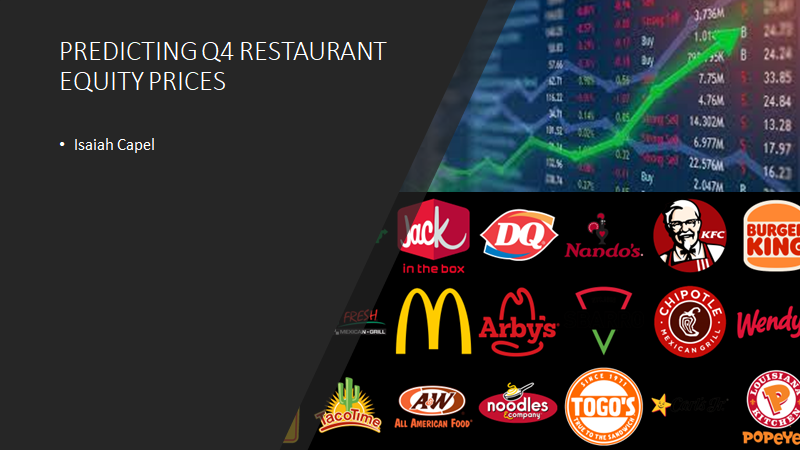

# SUMMARY

This notebook is intended for a hypothetical pension fund looking to cut out the hedge fund or private equity fees by looking to do their own trading. They have asked me to predict which of the top 14 American restaurant stocks will peform best and which will perform worst. 

Of course, examining the restaurant sector without also examining COIVD-19 numbers seems unwise since even 2.5 years in to COVID era, many of these businesses are still greatly depend on customers dining at their establishments. Therefore, I used data from the Center for Disease Control(CDC) to predict the COVID numbers for the rest of the year. Then, I made an LSTM model of closing prices for all 14 companies over the last 5 years with the exogenous variable of COVID deaths. Then, I made predicitons on that model using the COVID numbers that I predicted. I conlcuded that **Cracker Barrel, Papa John's, and Dominos would perform best while Darden, Chipotle, and Wingstop will perfrom worst.**



# BUSINESS UNDERSTANDING

Currently, the market is in a period of uncertainty. Interest rate hikes, supply chain questions, international conflicts, and a still unrelenting but increasingly silent pandemic hover over the marketplace. For any investors looking to save on fees and do their own trading, these problems making profitable trading a daunting task. The restaurant industry, in particular, is vulnerable to so many of those issues. 

My task is to help navigate this perilous industry by providing you with the restaurant industry equities that will perform best in the remainder of this year and the equities that will perform worse. I am using closing price data from Yahoo Finance. Yahoo Finance is an incredibly rich source of finance data. These predictions should refelct the company's preparedness for the current conditions like a COVID surge. I will recommend stock by measuring which has the highest ROI%:

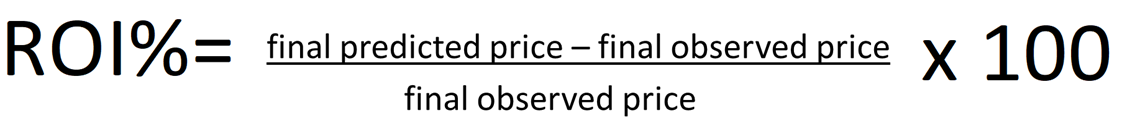

# DATA UNDERSTANDING

To properly model and predict restaurant equity prices in today's world, it's essential to include COVID-19 numbers. There were many "COVID-19 numbers" that I could have used but I decided to use deaths from COVID-19. In another iteration of this work, I may use infection rates but my intuition tells me that people generally worry less about infection nowdays. Basically, increasing infection numbers probably wouldn't alarm consumers but increasing death numbers would deter them from visitng dining establishments in person. 

My COVID-19 death numbers are on a 7 day delay. The reasons are simple: 1:) the CDC takes a week to release results, 2.) the market can take a while to react to COVID numbers. In fact, there is evidence that the market can take very long to react: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8426993/

I used Yahoo Finance site to obtain my price data. I chose to settle on closing price data although intraday price points could be included as well. Each stock in this dataset has, as a prerequisite for examining 5 years of trading, traded for at least 5 years.

**The main metric I use in this notebook is Mean Absolute Percentage Error(MAPE)** because of its universality. I compare between different models and between different stocks. MAPE is great for comparing between very disparate types of values. I will predict prices using multiple models and therefore I need a metric that will provide useful information between models and stocks inside of models. Other metrics like RMSE and MAE would not be helpful in comparing the model's performance on, for example, Chipotle(currently priced in the 4 digits) and Wendy's (trading around 20 dollars). 

# DATA PREPARATION

First things first: I need to import a plethora of libraries and modules:

In [1]:



import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError 
from tensorflow.keras.optimizers import Adam
from numpy.random import seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection
from numpy import asarray

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

%matplotlib inline
# downloading and opening the excel file with the 5 year data
restaurants = pd. read_excel ("5_year_restaurant_prices.xlsx")
restaurants

Date   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1330 2022-12-26         NaN        NaN         NaN        NaN   
1331 2022-12-27         NaN        NaN         NaN        NaN   
1332 2022-12-28         NaN        NaN         NaN        NaN   
1333 2022-12-29         NaN        NaN         NaN        NaN   
1334 2022-12-30         NaN        NaN         NaN        NaN   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1330                    NaN        NaN         NaN     NaN        NaN   
1331                    NaN        NaN         NaN     NaN        NaN   
1332                    NaN        NaN         NaN     NaN        NaN   
1333                    NaN        NaN         NaN     NaN        NaN   
1334                    NaN        NaN         NaN     NaN        NaN   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      74.699997      149.550003    32.580002       17.420000       100.199997  
1      73.660004      150.399994    32.950001       17.510000       101.040001  
2      73.070000      151.619995    33.230000       17.600000       101.919998  
3      72.559998      153.899994    33.389999       17.639999       100.589996  
4      70.610001      153.210007    33.139999       17.170000        99.339996  
...          ...             ...          ...             ...              ...  
1330         NaN             NaN          NaN             NaN              NaN  
1331         NaN             NaN          NaN             NaN              NaN  
1332         NaN             NaN          NaN             NaN              NaN  
1333         NaN             NaN          NaN             NaN              NaN  
1334         NaN             NaN          NaN             NaN              NaN  

[1335 rows x 15 columns]

In [2]:
restaurants.iloc[1267:]

Date  McDonalds  Starbucks  Chipotle  Yum  Restaurant Brands Int  \
1267 2022-10-10        NaN        NaN       NaN  NaN                    NaN   
1268 2022-10-11        NaN        NaN       NaN  NaN                    NaN   
1269 2022-10-12        NaN        NaN       NaN  NaN                    NaN   
1270 2022-10-13        NaN        NaN       NaN  NaN                    NaN   
1271 2022-10-14        NaN        NaN       NaN  NaN                    NaN   
...         ...        ...        ...       ...  ...                    ...   
1330 2022-12-26        NaN        NaN       NaN  NaN                    NaN   
1331 2022-12-27        NaN        NaN       NaN  NaN                    NaN   
1332 2022-12-28        NaN        NaN       NaN  NaN                    NaN   
1333 2022-12-29        NaN        NaN       NaN  NaN                    NaN   
1334 2022-12-30        NaN        NaN       NaN  NaN                    NaN   

      Darden  Dominos  Wendys  Wingstop  Papa Johns  Cracker Barrel  \
1267     NaN      NaN     NaN       NaN         NaN             NaN   
1268     NaN      NaN     NaN       NaN         NaN             NaN   
1269     NaN      NaN     NaN       NaN         NaN             NaN   
1270     NaN      NaN     NaN       NaN         NaN             NaN   
1271     NaN      NaN     NaN       NaN         NaN             NaN   
...      ...      ...     ...       ...         ...             ...   
1330     NaN      NaN     NaN       NaN         NaN             NaN   
1331     NaN      NaN     NaN       NaN         NaN             NaN   
1332     NaN      NaN     NaN       NaN         NaN             NaN   
1333     NaN      NaN     NaN       NaN         NaN             NaN   
1334     NaN      NaN     NaN       NaN         NaN             NaN   

      Shake Shack  Bloomin Brands  Jack in the Box  
1267          NaN             NaN              NaN  
1268          NaN             NaN              NaN  
1269          NaN             NaN              NaN  
1270          NaN             NaN              NaN  
1271          NaN             NaN              NaN  
...           ...             ...              ...  
1330          NaN             NaN              NaN  
1331          NaN             NaN              NaN  
1332          NaN             NaN              NaN  
1333          NaN             NaN              NaN  
1334          NaN             NaN              NaN  

[68 rows x 15 columns]

The null values in the latter part of the DataFrame represent future data points that have not yet come but will be predicted. Next, it's important to set the "Date" column to a datetime when using a time series:

In [3]:
restaurants['Date'] =pd.to_datetime(restaurants['Date'])

Next, "Date" must be made the index:

In [4]:
restaurants.index= restaurants['Date']
restaurants.drop(['Date'],axis=1, inplace=True)

Let's do some exploration and check for stationarity:

In [5]:
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

In [6]:
dftest_stationarity(restaurants.iloc[:1267].fillna(0))

('Restaurant Brands Int',
 (-3.2387994131264457,
  0.017845835632014112,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  3594.1956707712025))

Only Restaurant Brands Int is stationary.

In [7]:
# Checking for stationarity on log scaled data
restaurants_log=np.log(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_log)

('Restaurant Brands Int',
 (-3.57451147226002,
  0.006267432248044325,
  16,
  1250,
  {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
  -6259.063295187531))

Again, only Restaurant Brands Int is stationary.

In [8]:
# Checking for stationarity on square root data

restaurants_sqrt = np.sqrt(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_sqrt)

('Restaurant Brands Int',
 (-3.460165355062584,
  0.009071043465808885,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  -3080.094514204029))

Once again, only Restaurant Brands International is stationary.

Next, I will import the death numbers into the DataFrame:

# COVID-19 MODELING

Now, let's take a look at the covid death numbers:

In [9]:
ts = pd.read_excel ("7day delay.xlsx")
# Making column 'ds' into a datetime
ts['ds'] =pd.to_datetime(ts['ds'])
ts

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Ok, as you can see, there are no numbers yet for future dates. We will have to predict those.

Let's make a copy of the dataset

In [10]:
ts_copy=ts.copy(deep=True)

ts_copy['ds'] =pd.to_datetime(ts_copy['ds'])
#ts_copy.index= ts_copy['ds']
#ts_copy.drop(['ds'],axis=1, inplace=True)
ts_copy.index
ts_copy

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Let's use the square root of the death numbers:

In [11]:
ts_sqrt=ts.copy(deep=True)
ts_sqrt['y']=np.sqrt(ts_sqrt['y'])
ts_sqrt.iloc[989:]

ds   y
989  2022-10-12 NaN
990  2022-10-13 NaN
991  2022-10-14 NaN
992  2022-10-17 NaN
993  2022-10-18 NaN
...         ...  ..
1050 2022-12-26 NaN
1051 2022-12-27 NaN
1052 2022-12-28 NaN
1053 2022-12-29 NaN
1054 2022-12-30 NaN

[66 rows x 2 columns]

Let's set the index for ts to the 'ds' column because we may have to use this DataFrame later.

In [12]:
ts.set_index('ds', inplace=True)

In [13]:
ts_sqrt

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

## XGBoost Regressor

The 1st model I will employ for modeling COVID-19 deaths is XGBoost Regressor. This is actually not a specialized time-series model but is known for being extremely effective at solving almost any task. However, in order to use, I must extract features of the data. Therefore, I will extract the day, month, and year from the date column.

In [14]:
ts_sqrt_clone= ts_sqrt.iloc[:989].copy(deep=True)
ts_sqrt_clone
ts_sqrt_clone.set_index('ds', inplace=True)
ts_sqrt_clone

y
ds                   
2020-01-23   0.000000
2020-01-24   0.000000
2020-01-25   0.000000
2020-01-26   0.000000
2020-01-27   0.000000
...               ...
2022-10-05  13.527749
2022-10-06  21.330729
2022-10-07  27.129320
2022-10-10  25.534291
2022-10-11  18.000000

[989 rows x 1 columns]

In [15]:
#Extracting the day, year, and month and making them into columns
ts_sqrt_clone['month'] = ts_sqrt_clone.index.month
ts_sqrt_clone['year'] = ts_sqrt_clone.index.year
ts_sqrt_clone['dayofmonth'] = ts_sqrt_clone.index.day


ts_sqrt_clone

y  month  year  dayofmonth
ds                                            
2020-01-23   0.000000      1  2020          23
2020-01-24   0.000000      1  2020          24
2020-01-25   0.000000      1  2020          25
2020-01-26   0.000000      1  2020          26
2020-01-27   0.000000      1  2020          27
...               ...    ...   ...         ...
2022-10-05  13.527749     10  2022           5
2022-10-06  21.330729     10  2022           6
2022-10-07  27.129320     10  2022           7
2022-10-10  25.534291     10  2022          10
2022-10-11  18.000000     10  2022          11

[989 rows x 4 columns]

In [16]:
# Creating the training set
X_train=ts_sqrt_clone.iloc[:923,1:]
y_train=ts_sqrt_clone.iloc[:923,:1]


In [17]:
X_train

month  year  dayofmonth
ds                                 
2020-01-23      1  2020          23
2020-01-24      1  2020          24
2020-01-25      1  2020          25
2020-01-26      1  2020          26
2020-01-27      1  2020          27
...           ...   ...         ...
2022-07-29      7  2022          29
2022-07-30      7  2022          30
2022-07-31      7  2022          31
2022-08-01      8  2022           1
2022-08-02      8  2022           2

[923 rows x 3 columns]

In [18]:
# A grid search for optimal parameters
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
xgb1 = XGBRegressor(random_state=42)
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, .07], 
              'max_depth': [5, 6, 8],
              'min_child_weight': [4,7],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200,500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[16:56:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


-0.36044586302751724
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [19]:
#Fitting on the optimized parameters
model_xgb = XGBRegressor(colsample_bytree= .7, learning_rate=  0.03, max_depth= 6, min_child_weight= 4, subsample= 0.7, n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=6, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
#Creating a test set
X_test=ts_sqrt_clone.iloc[923:,1:]

y_test=ts_sqrt_clone.iloc[923:,:1]
X_test

month  year  dayofmonth
ds                                 
2022-08-03      8  2022           3
2022-08-04      8  2022           4
2022-08-05      8  2022           5
2022-08-06      8  2022           6
2022-08-07      8  2022           7
...           ...   ...         ...
2022-10-05     10  2022           5
2022-10-06     10  2022           6
2022-10-07     10  2022           7
2022-10-10     10  2022          10
2022-10-11     10  2022          11

[66 rows x 3 columns]

In [21]:
xgb_preds=model_xgb.predict(X_train)
print("Train RMSE: %.3f" % (mean_absolute_percentage_error(y_train**2, xgb_preds**2)))
print("MAE Train: %.3f" % (mean_absolute_error(y_train**2,xgb_preds**2)))


Train RMSE: 22950901971408344.000
MAE Train: 379.043


In [22]:
xgb_preds_test=model_xgb.predict(X_test)
print("MAPE Test: %.3f" %(mean_absolute_percentage_error(y_test**2, xgb_preds_test**2)))
print("MAE test: %.3f" % (mean_absolute_error(y_test**2, xgb_preds_test**2)*100))


MAPE Test: 3.118
MAE test: 55256.299


In [23]:
xgb_preds_test

array([27.655396, 27.88299 , 26.9675  , 27.532751, 28.836899, 29.111382,
       27.697245, 28.36855 , 28.564058, 28.105946, 28.298477, 29.430876,
       29.593542, 28.378006, 28.413877, 29.068153, 28.079138, 28.104498,
       29.357445, 29.560907, 28.922943, 29.879116, 29.384491, 28.216076,
       28.203548, 29.602627, 28.77817 , 26.534035, 27.076057, 34.076946,
       33.120293, 34.097782, 34.20866 , 32.775776, 33.118008, 34.02203 ,
       34.29651 , 33.0018  , 33.673103, 33.77278 , 33.322403, 33.65896 ,
       34.73439 , 34.96101 , 33.74548 , 33.78135 , 33.822582, 32.833565,
       32.858925, 34.296284, 34.66495 , 33.778027, 34.524612, 33.703526,
       32.560997, 32.578224, 33.89856 , 33.47875 , 31.151922, 32.462395,
       32.57327 , 31.35017 , 31.648573, 32.492794, 31.821018, 31.92069 ],
      dtype=float32)

XGBoost Regressor COVID MAPE: 311.757
XGBoost Regressor COVID MAE: 552.563


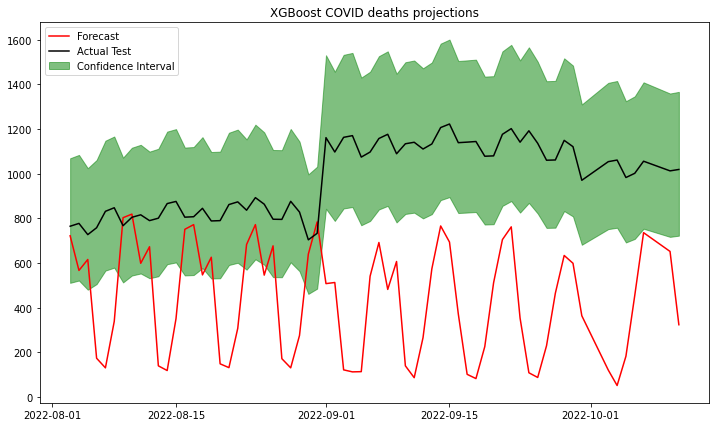

In [24]:
for x in xgb_preds_test:
    interval = 1.96 * xgb_preds_test.std()
    lower, upper = xgb_preds_test - interval, xgb_preds_test + interval
print("XGBoost Regressor COVID MAPE: %.3f" %(mean_absolute_percentage_error(y_test**2, xgb_preds_test**2)*100))
print("XGBoost Regressor COVID MAE: %.3f" %(mean_absolute_error(y_test**2, xgb_preds_test**2)))


plt.figure(figsize=(12,7))
 
plt.plot(ts_sqrt_clone.index[923:], y_test**2, 'r')
plt.plot(ts_sqrt_clone.index[923:], xgb_preds_test**2, 'black')
plt.fill_between(ts_sqrt_clone.index[923:], lower[:66]**2, upper[:66]**2, color="green", alpha=0.5)
plt.legend(['Forecast','Actual Test', 'Confidence Interval'], loc='upper left')
plt.title('XGBoost COVID deaths projections');




Both the MAE and MAPE are very high. Perhaps Prophet will produce better results.

## Prophet

Now let's use Facebook's Prophet to examine the COVID numbers:

In [25]:
from prophet import Prophet

covid_model = Prophet(interval_width=0.95)
covid_model.fit(ts_sqrt.iloc[:923])

Importing plotly failed. Interactive plots will not work.
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing


Let's look at the results on the training and test data:

Prophet COVID MAPE: 42.887
Prophet COVID MAE: 278.998


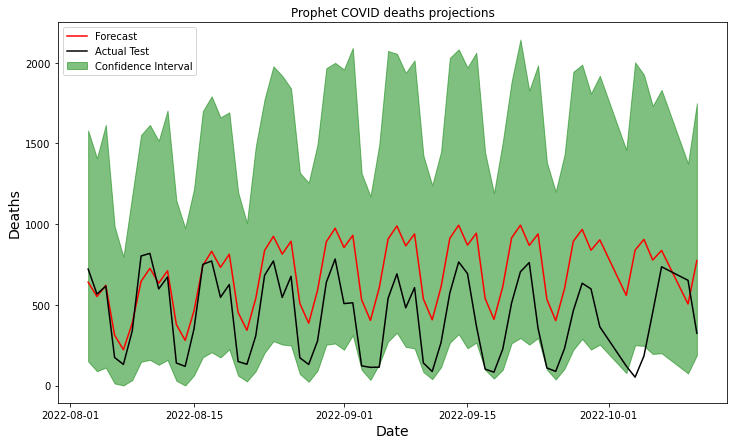

In [26]:
from datetime import datetime
from pandas import DataFrame

from pandas import to_datetime
# Using 66 dates because that is the number of values we need to predict for on the unseen data
future = DataFrame(ts.index[923:989])
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast =  covid_model.predict(future)
# Calculating the MAPE
# Values from DataFrame 'forecast' must be squared to compare with original data

print("Prophet COVID MAPE: %.3f" % (mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100))
print("Prophet COVID MAE: %.3f" % (mean_absolute_error(forecast['yhat']**2,ts.iloc[923:989] )))

prophet_covid_mape=mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100


# Values from DataFrame 'forecast' must be squared to compare with original data
plt.figure(figsize=(12,7))

plt.plot(ts.index[923:989],forecast['yhat']**2, 'r')
plt.plot(ts.index[923:989], ts.iloc[923:989], 'black')
plt.fill_between(ts.index[923:989], forecast['yhat_upper']**2, forecast['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Forecast','Actual Test', 'Confidence Interval'], loc='upper left')    
plt.title('Prophet COVID deaths projections')

plt.show()


A 43% MAPE is not ideal. The MAE puts the model performance is more concrete terms. A model that is off by 278 deaths daily isn't ideal especially when COVID-19 deaths are declining nationwide. Therefore, it is necessary to employ another model. Therefore, I will try an LSTM model next.

## LSTM COVID MODEL

In [27]:
#Setting the index to 'ds' so the DataFrame can be used in an LSTM
ts_sqrt.set_index('ds', inplace=True)


In order to use an LSTM, I need to make the values of the DataFrame into a tensor. That's the next task:

In [28]:
# Making the DataFrame values into tensors
def create_dataset(X, y, lag=1):
    #Creating a split into an x(dependent variable) and a y(predicted/independent variable)
    xs,ys = [], []
    #For loop to append on each value of the DataFrame
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

(913, 1) is train shape
Epoch 1/10
91/91 [==============================] - 4s 9ms/step - loss: 211.9098
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 43.3662
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 43.4728
Epoch 4/10
91/91 [==============================] - 1s 7ms/step - loss: 40.9418
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 36.8343
Epoch 6/10
91/91 [==============================] - 1s 7ms/step - loss: 34.9730
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 34.1247
Epoch 8/10
91/91 [==============================] - 1s 7ms/step - loss: 31.2002
Epoch 9/10
91/91 [==============================] - 1s 10ms/step - loss: 31.2773
Epoch 10/10
3/3 [==============================] - 1s 6ms/step
Deaths LSTM MAPE: 162.742
LSTM COVID MAE: 346.355


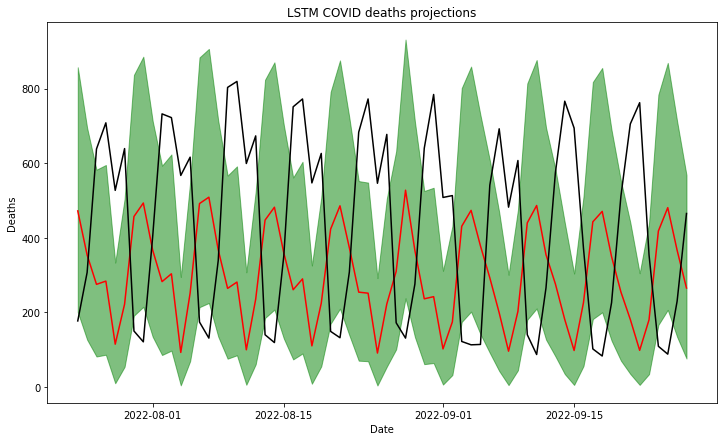

In [29]:
training = ts_sqrt.iloc[:913]
training
#testing = exogenous_df.iloc[1158:1208]
next_= ts_sqrt.iloc[913:989].fillna(0)
print(training.shape, 'is train shape')

xtrain, ytrain = create_dataset(training, training.iloc[:,0], 10)
xnext, ynext=create_dataset(next_, next_.iloc[:,0],10)

model = Sequential()
model.add(LSTM(76,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(xtrain, ytrain,
          epochs=10,
          batch_size=10,
          verbose=1,
          shuffle=False
         )

ypred = model.predict(xnext)

ypred = asarray(ypred)
for x in ypred[:]:
    interval = 1.96 * ypred.std()
    lower, upper = ypred - interval, ypred + interval

plt.figure(figsize=(12,7))
#10 values are lost due to lag. 
plt.plot(ts_sqrt.index[913:979], ypred**2, 'r', label="Predictions")
plt.plot(ts_sqrt.index[913:979], next_.iloc[:66,0]**2, 'black', label="Actual")
plt.fill_between(ts_sqrt.index[913:979], lower[:66, 0]**2, upper[:66, 0]**2, color="green", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.title('LSTM COVID deaths projections')

print("Deaths LSTM MAPE: %.3f" % (mean_absolute_percentage_error(ypred**2, next_.iloc[:66,0]**2)*100))
print("LSTM COVID MAE: %.3f" % (mean_absolute_error(ypred**2, next_.iloc[:66,0]**2)))


That isn't what I was hoping for. That number is too high. The MAPE remains too high. Even running the model multiple times, I obtain results that are too high. It's probably best to use the Prophet model.

Here's how my predictions compare. Note, the predictions at this website are for 4 weeks intervals. 

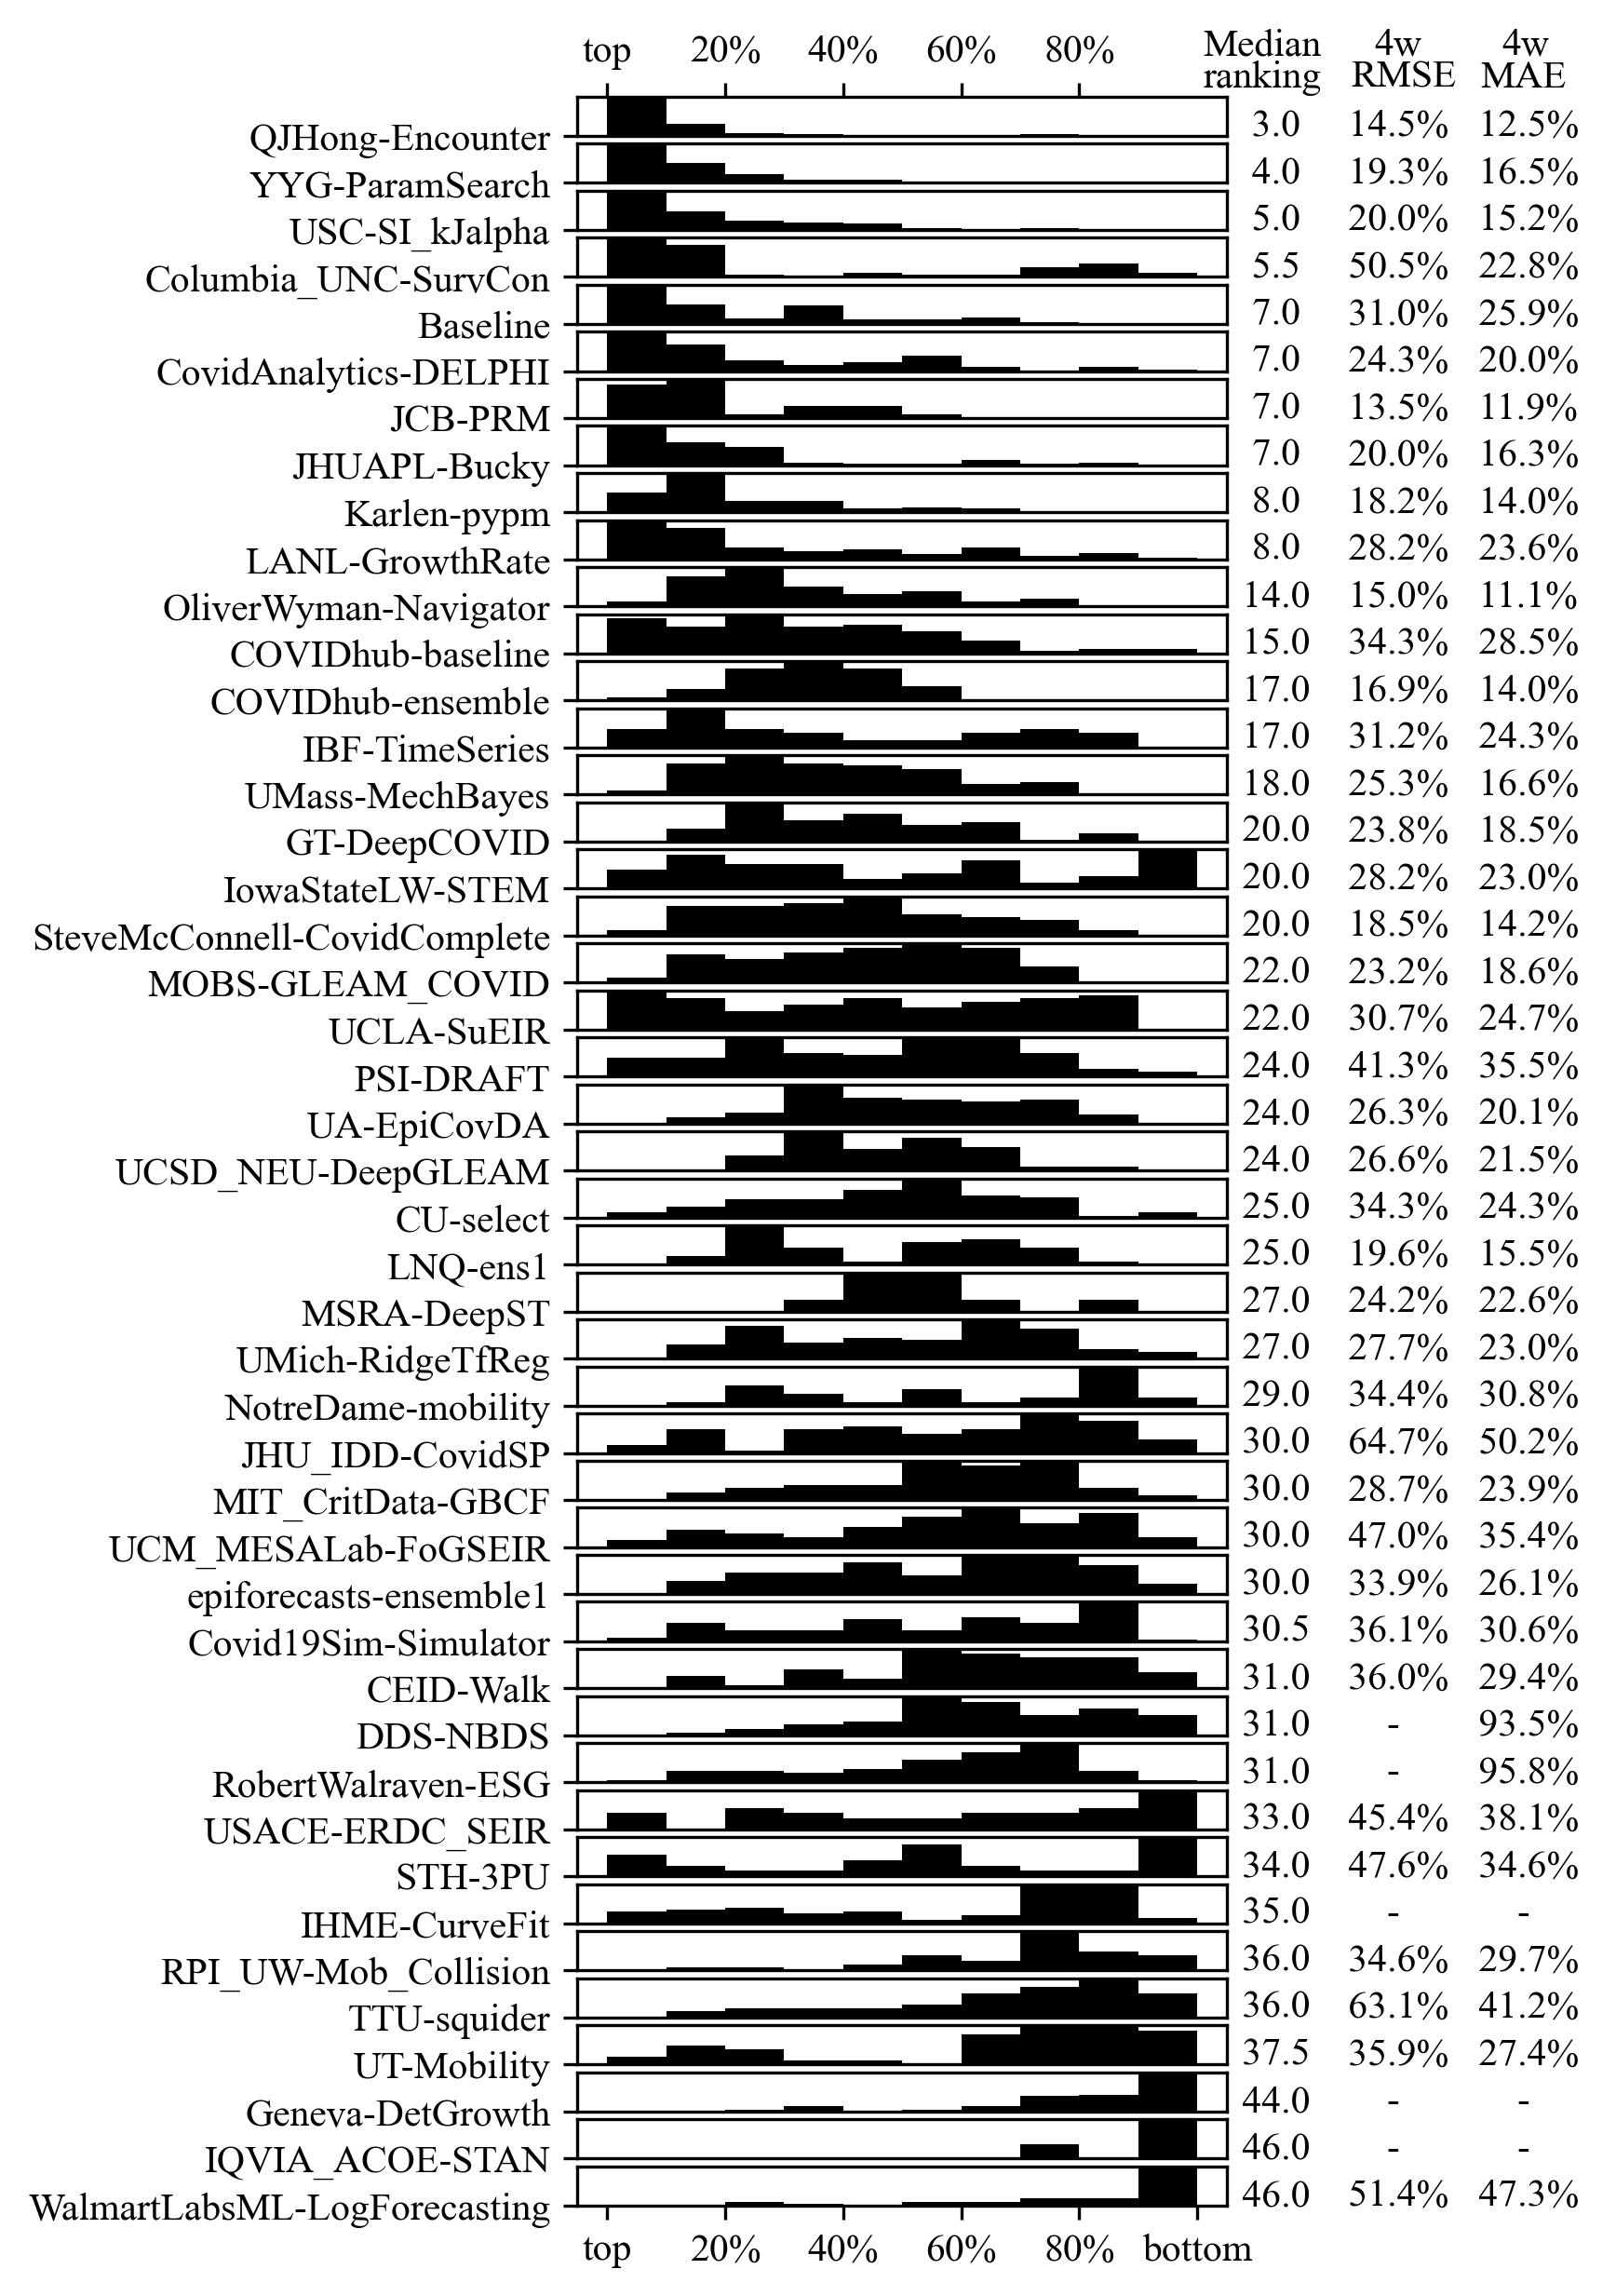

Source:https://qjhong.github.io/

As you can see, my Prophet model is certainly not elite but it also scores beter than some of the other models. Moreover, my model spans 2.5 months while the above models only account for 4 weeks in the future. Therefore, I will use Prophet model since it performed best.

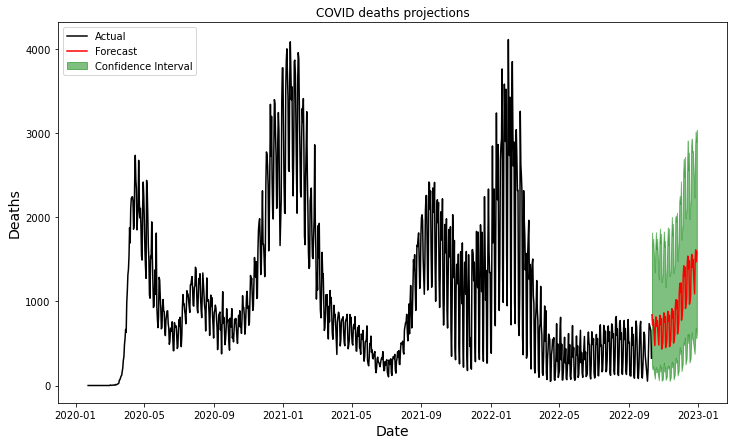

In [30]:
out_of_sample = DataFrame(ts.index[989:1055])
out_of_sample['ds']= to_datetime(out_of_sample['ds'])

predictions=covid_model.predict(out_of_sample)
plt.figure(figsize=(12,7))
plt.plot(ts.index[:989],ts['y'].iloc[:989], 'black')

plt.plot(ts.index[989:1055],predictions['yhat']**2, 'r')
plt.fill_between(ts.index[989:1055], predictions['yhat_upper']**2, predictions['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Actual','Forecast','Confidence Interval'], loc='upper left')    
plt.title('COVID deaths projections')

plt.show()

**OK, now that I have predictions, let's model the price data!**

# PRICE MODELING

## Auto-Arima

The 1st model I will employ is an Auto-Arima model.

Let's merge the price data with the death data:

In [31]:
# Merge on restaurants index.
merged=restaurants.merge(ts, how='left',left_on=restaurants.index, right_on=ts.index)
#Filling any null with 0.
merged.fillna(0, inplace=True)
#Renaming the "y" column in ts_copy with deaths
merged.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
merged.set_index('Dates', inplace=True)
merged

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26         0.000000     0.0  
2022-12-27         0.000000     0.0  
2022-12-28         0.000000     0.0  
2022-12-29         0.000000     0.0  
2022-12-30         0.000000     0.0  

[1335 rows x 15 columns]

Making a copy and setting its index to 'Dates':

In [32]:
merged_copy=merged.copy(deep=True)
#merged_copy.set_index('Dates', inplace=True)
merged_copy

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26         0.000000     0.0  
2022-12-27         0.000000     0.0  
2022-12-28         0.000000     0.0  
2022-12-29         0.000000     0.0  
2022-12-30         0.000000     0.0  

[1335 rows x 15 columns]

In [33]:
# A Dataframe with no future values
merged_insample=merged.iloc[:1267,:]
#merged_insample.set_index('Dates', inplace=True)
merged_insample.asfreq('d').index
merged_insample

McDonalds  Starbucks     Chipotle         Yum  \
Dates                                                        
2017-09-27  154.050003  54.990002   313.850006   73.099998   
2017-09-28  157.490005  54.500000   316.529999   73.500000   
2017-09-29  156.679993  53.709999   307.829987   73.610001   
2017-10-02  156.960007  53.810001   301.809998   73.750000   
2017-10-03  156.860001  53.990002   302.989990   73.919998   
...                ...        ...          ...         ...   
2022-10-03  235.340000  85.620000  1468.160000  109.110000   
2022-10-04  238.500000  88.510000  1524.200000  111.410000   
2022-10-05  239.090000  90.120000  1495.860000  112.330000   
2022-10-06  234.750000  89.350000  1506.010000  110.120000   
2022-10-07  233.190000  87.030000  1465.310000  108.930000   

            Restaurant Brands Int      Darden     Dominos  Wendys    Wingstop  \
Dates                                                                           
2017-09-27              63.869999   79.150002  196.839996   15.58   33.540001   
2017-09-28              63.880001   78.959999  197.039993   15.57   33.340000   
2017-09-29              63.880001   78.779999  198.550003   15.53   33.250000   
2017-10-02              64.269997   79.169998  199.990005   15.29   33.610001   
2017-10-03              64.040001   80.110001  202.809998   15.47   33.480000   
...                           ...         ...         ...     ...         ...   
2022-10-03              54.110000  125.410000  316.440000   18.95  123.030000   
2022-10-04              55.480000  132.220000  330.610000   19.47  128.760000   
2022-10-05              55.130000  133.100000  335.130000   19.56  137.650000   
2022-10-06              53.580000  129.510000  324.220000   19.54  133.040000   
2022-10-07              52.310000  125.690000  314.520000   19.10  128.320000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-10-03   73.450000       91.410000    45.630000       18.440000   
2022-10-04   75.560000       97.150000    46.560000       19.600000   
2022-10-05   74.430000       96.450000    46.460000       19.890000   
2022-10-06   71.810000       95.010000    47.840000       19.680000   
2022-10-07   68.680000       91.450000    46.690000       19.360000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-10-03        72.630000   121.0  
2022-10-04        77.130000    52.0  
2022-10-05        77.700000   183.0  
2022-10-06        75.400000   455.0  
2022-10-07        74.750000   736.0  

[1267 rows x 15 columns]

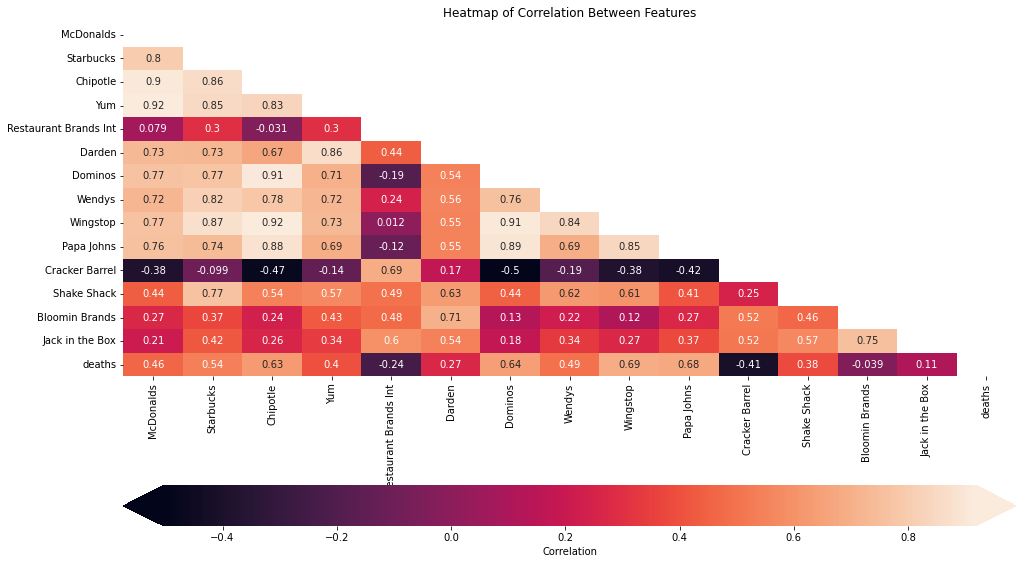

In [34]:
#Correlations
stock_deaths_corr = merged_insample.corr()
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    data=stock_deaths_corr,
    mask=np.triu(np.ones_like(stock_deaths_corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
ax.set_title("Heatmap of Correlation Between Features");

In [35]:
print(1267-(69*2), 'training days for all models')


1129 training days for all models


In [36]:
%%time

error_dict_percent=dict();
def stonks(stocks):
    # train size= 1-(138/1267)=0.8910812943962115
    train, test = model_selection.train_test_split(stocks, train_size= 0.8910812943962115 )
    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_0 = pm(train, exogenous= merged_insample[['deaths']].iloc[:1129], start_p=1, start_q=1, start_P=1, start_Q=1,
                 max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,stepwise=True, suppress_warnings=True, 
                 D=5, max_D=5,error_action='ignore')
    #printing model summary
    print(model_0.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    preds_0, conf_int = model_0.predict(n_periods=69, exogenous= merged_copy[['deaths']].iloc[1129 :1198], 
                                        return_conf_int=True)
    
    
    #Print the errors:

    print("Validation MAPE: %.3f" % np.sqrt(mean_absolute_percentage_error(test.iloc[:69], preds_0)*100))
    print("Validation MAE: %.3f" % (mean_absolute_error(test.iloc[:69], preds_0)))
    percent_error=mean_absolute_percentage_error(test.iloc[:69], preds_0)*100

   

    plt.figure(figsize=(12,6))
    plt.plot(merged_insample.index[:1129], train)
    plt.plot(merged_insample.index[1129 :1198], test.iloc[:69])
    plt.plot(merged_insample.index[1129 :1198], preds_0)
    plt.fill_between(merged_insample.index[1129 :1198], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{stocks.name} Price')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    error_dict_percent[stocks.name]=percent_error

stop = timeit.default_timer()
    

Wall time: 0 ns


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2742.890
Date:                Mon, 24 Oct 2022   AIC                           5499.780
Time:                        16:57:27   BIC                           5534.977
Sample:                             0   HQIC                          5513.079
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths     -5.377e-05      0.000     -0.169      0.866      -0.001       0.001
ar.L1         -0.1249      0.018     -7.048      0.000      -0.160      -0.090
ar.L2          0.0738      0.013      5.474      0.0

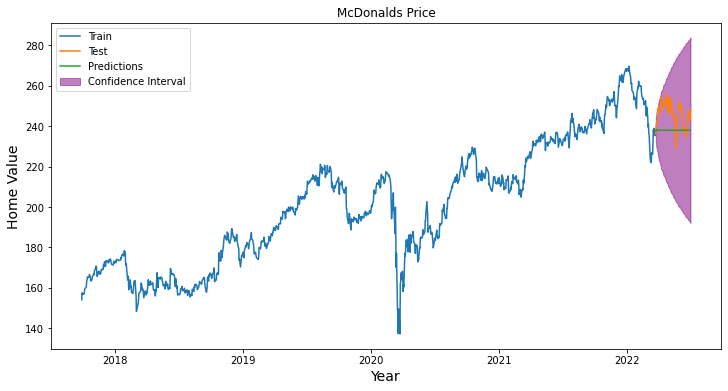

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2024.361
Date:                Mon, 24 Oct 2022   AIC                           4054.722
Time:                        16:57:33   BIC                           4069.807
Sample:                             0   HQIC                          4060.422
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      3.025e-06      0.000      0.024      0.981      -0.000       0.000
ar.L1         -0.1019      0.016     -6.214      0.000      -0.134      -0.070
sigma2         2.1217      0.044     48.424      0.0

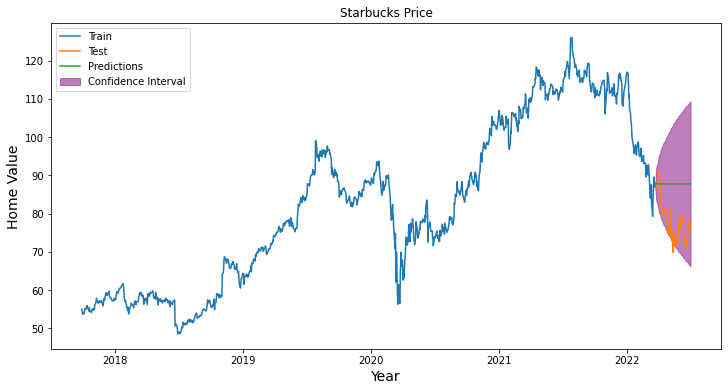

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -5067.621
Date:                Mon, 24 Oct 2022   AIC                          10143.243
Time:                        16:57:37   BIC                          10163.356
Sample:                             0   HQIC                         10150.842
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0507      0.665      1.579      0.114      -0.253       2.355
deaths         0.0051      0.001      3.591      0.000       0.002       0.008
ar.L1          0.0442      0.022      1.976      0.0

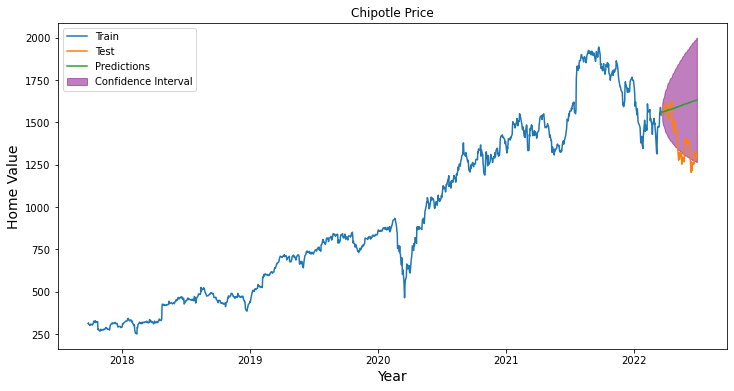

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2028.135
Date:                Mon, 24 Oct 2022   AIC                           4060.269
Time:                        16:57:39   BIC                           4070.325
Sample:                             0   HQIC                          4064.069
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      7.482e-05      0.000      0.531      0.595      -0.000       0.000
sigma2         2.1342      0.037     57.400      0.000       2.061       2.207
Ljung-Box (L1) (Q):                   0.60   Jarque-

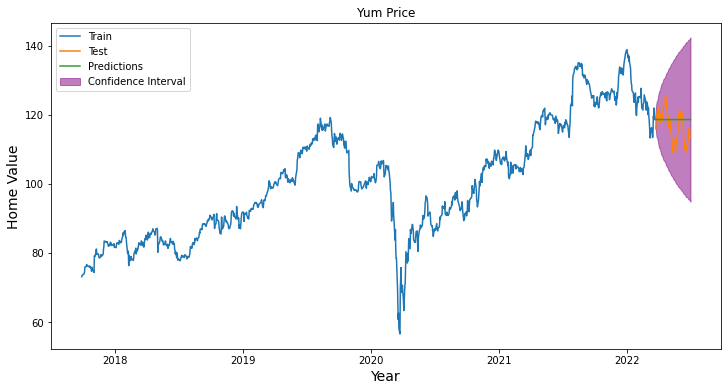

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1660.138
Date:                Mon, 24 Oct 2022   AIC                           3324.276
Time:                        16:57:42   BIC                           3334.333
Sample:                             0   HQIC                          3328.076
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      6.098e-05      0.000      0.546      0.585      -0.000       0.000
sigma2         1.1110      0.018     60.743      0.000       1.075       1.147
Ljung-Box (L1) (Q):                   1.38   Jarque-

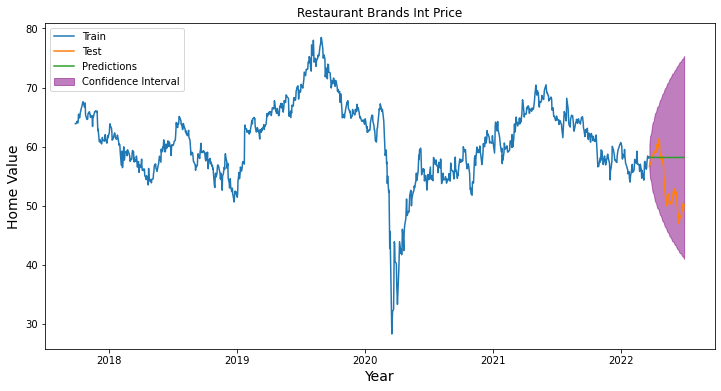

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2636.394
Date:                Mon, 24 Oct 2022   AIC                           5276.787
Time:                        16:57:44   BIC                           5286.844
Sample:                             0   HQIC                          5280.587
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0002      0.000      0.626      0.531      -0.000       0.001
sigma2         6.2751      0.119     52.805      0.000       6.042       6.508
Ljung-Box (L1) (Q):                   0.05   Jarque-

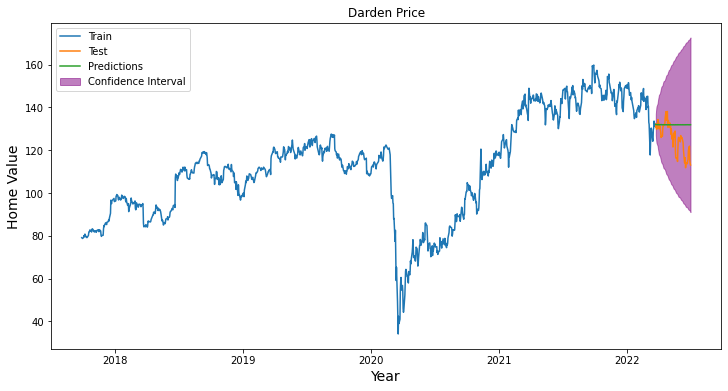

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3755.356
Date:                Mon, 24 Oct 2022   AIC                           7516.713
Time:                        16:57:48   BIC                           7531.797
Sample:                             0   HQIC                          7522.412
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths        -0.0009      0.001     -1.449      0.147      -0.002       0.000
ar.L1         -0.1055      0.023     -4.646      0.000      -0.150      -0.061
sigma2        45.6696      0.528     86.441      0.0

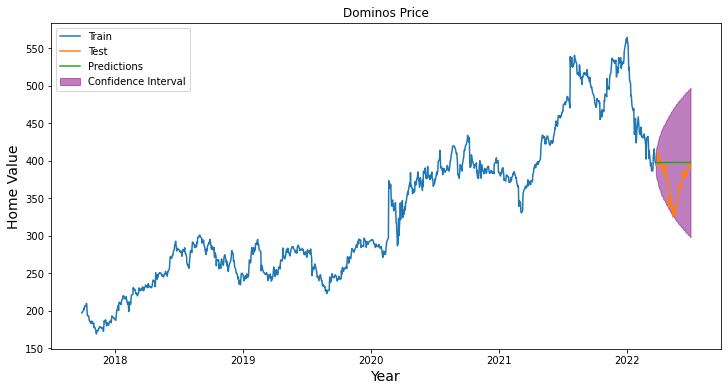

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -738.055
Date:                Mon, 24 Oct 2022   AIC                           1482.110
Time:                        16:57:54   BIC                           1497.194
Sample:                             0   HQIC                          1487.809
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths     -2.079e-05   5.74e-05     -0.362      0.717      -0.000    9.16e-05
ar.L1         -0.0930      0.008    -10.983      0.000      -0.110      -0.076
sigma2         0.2169      0.002    103.493      0.0

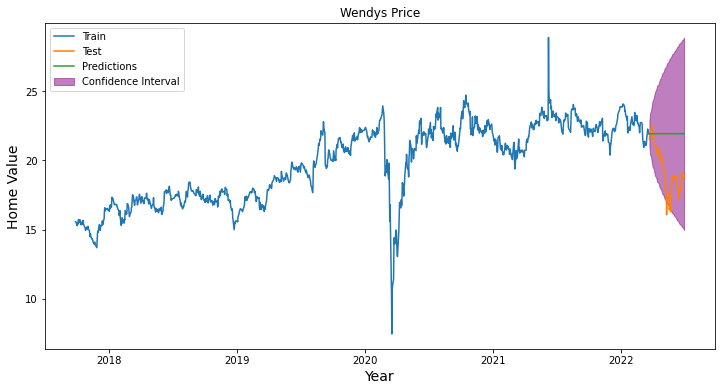

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2803.636
Date:                Mon, 24 Oct 2022   AIC                           5613.273
Time:                        16:57:59   BIC                           5628.358
Sample:                             0   HQIC                          5618.972
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0005      0.000      2.290      0.022    7.15e-05       0.001
ar.L1          0.0716      0.019      3.728      0.000       0.034       0.109
sigma2         8.4485      0.157     53.697      0.0

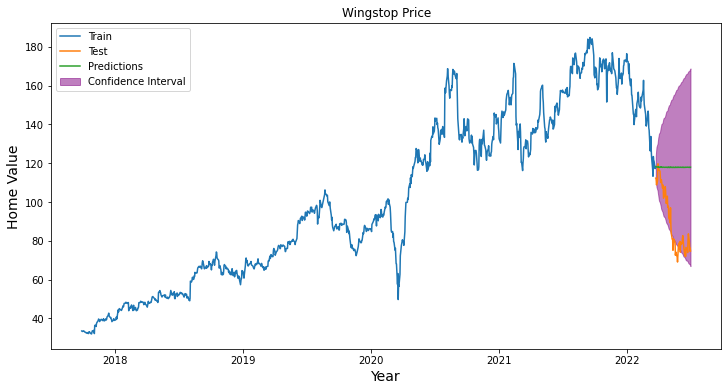

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2333.353
Date:                Mon, 24 Oct 2022   AIC                           4670.705
Time:                        16:58:02   BIC                           4680.762
Sample:                             0   HQIC                          4674.505
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0002      0.000      1.712      0.087   -3.31e-05       0.000
sigma2         3.6650      0.062     58.879      0.000       3.543       3.787
Ljung-Box (L1) (Q):                   2.56   Jarque-

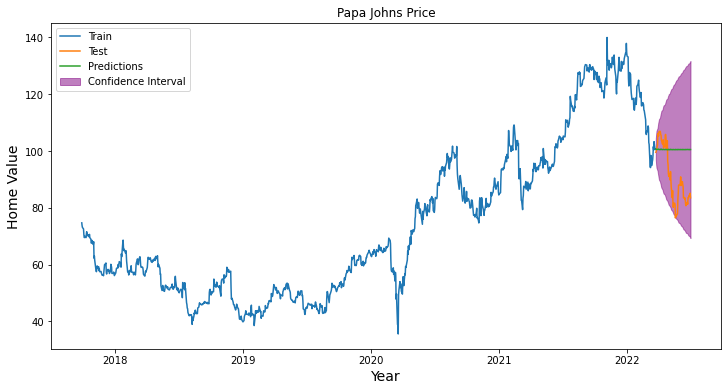

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2882.953
Date:                Mon, 24 Oct 2022   AIC                           5769.906
Time:                        16:58:03   BIC                           5779.962
Sample:                             0   HQIC                          5773.706
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths        -0.0003      0.000     -1.044      0.297      -0.001       0.000
sigma2         9.7157      0.206     47.068      0.000       9.311      10.120
Ljung-Box (L1) (Q):                   1.09   Jarque-

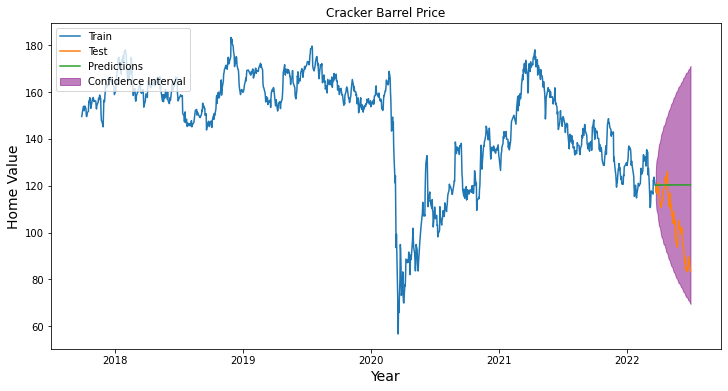

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2562.197
Date:                Mon, 24 Oct 2022   AIC                           5128.395
Time:                        16:58:06   BIC                           5138.451
Sample:                             0   HQIC                          5132.195
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0004      0.000      2.033      0.042    1.27e-05       0.001
sigma2         5.5015      0.097     56.731      0.000       5.311       5.692
Ljung-Box (L1) (Q):                   2.47   Jarque-

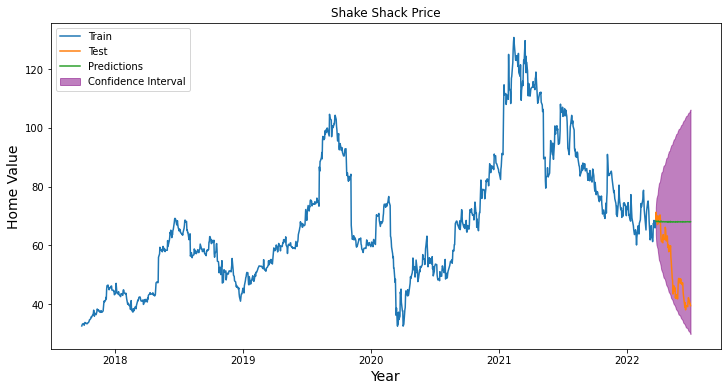

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -972.005
Date:                Mon, 24 Oct 2022   AIC                           1948.010
Time:                        16:58:08   BIC                           1958.067
Sample:                             0   HQIC                          1951.810
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      9.954e-08   5.83e-05      0.002      0.999      -0.000       0.000
sigma2         0.3285      0.007     45.591      0.000       0.314       0.343
Ljung-Box (L1) (Q):                   2.16   Jarque-

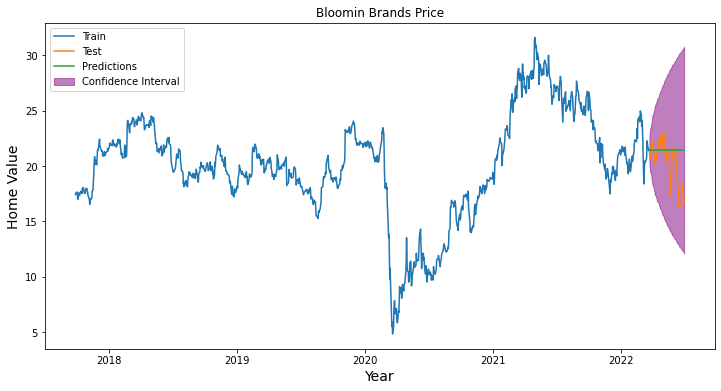

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2292.341
Date:                Mon, 24 Oct 2022   AIC                           4588.682
Time:                        16:58:11   BIC                           4598.739
Sample:                             0   HQIC                          4592.482
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0001      0.000      0.512      0.609      -0.000       0.001
sigma2         3.4095      0.067     51.179      0.000       3.279       3.540
Ljung-Box (L1) (Q):                   1.00   Jarque-

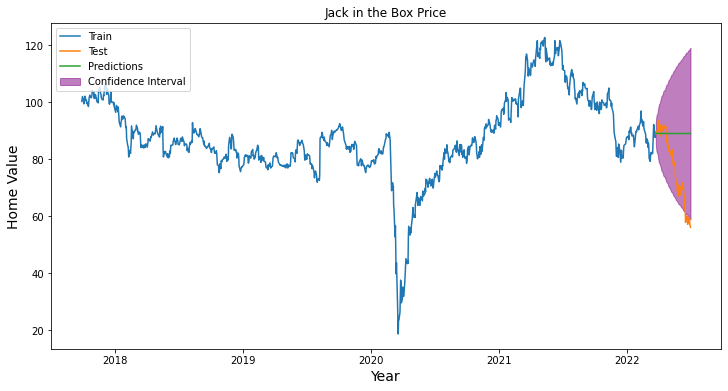

Wall time: 55.3 s


In [37]:
%%time

for x in merged_insample.iloc[:, :14]:
    stonks(merged_insample.iloc[:, :14][x])

stop = timeit.default_timer()

In [38]:
error_dict_percent

{'McDonalds': 3.5504125395317616,
 'Starbucks': 13.49113026935879,
 'Chipotle': 14.667804562345694,
 'Yum': 3.369135385409728,
 'Restaurant Brands Int': 9.558524136737764,
 'Darden': 6.033674052082082,
 'Dominos': 7.3036060445931295,
 'Wendys': 14.873850898016478,
 'Wingstop': 35.081750791712494,
 'Papa Johns': 13.353234960561863,
 'Cracker Barrel': 16.25855580861495,
 'Shake Shack': 34.589714062379734,
 'Bloomin Brands': 7.8227858070856096,
 'Jack in the Box': 18.90909179447443}

In [39]:
# Examining the MAPEs by creating a DataFrame of MAPEs
from operator import itemgetter, attrgetter
stocksss_errors= sorted(error_dict_percent.items(), key=itemgetter(0), reverse=True)
pm_stock_diffs_error_per= pd.DataFrame(stocksss_errors)
pm_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Auto Arima Percent Error'}, inplace=True )


In [40]:
pm_stock_diffs_error_per

Stock  Auto Arima Percent Error
0                     Yum                  3.369135
1                Wingstop                 35.081751
2                  Wendys                 14.873851
3               Starbucks                 13.491130
4             Shake Shack                 34.589714
5   Restaurant Brands Int                  9.558524
6              Papa Johns                 13.353235
7               McDonalds                  3.550413
8         Jack in the Box                 18.909092
9                 Dominos                  7.303606
10                 Darden                  6.033674
11         Cracker Barrel                 16.258556
12               Chipotle                 14.667805
13         Bloomin Brands                  7.822786

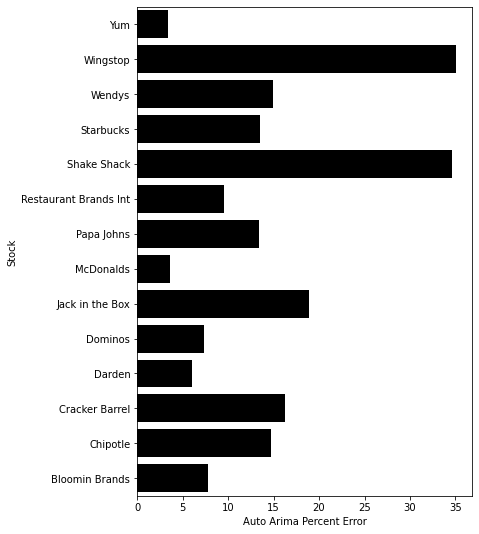

In [41]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Auto Arima Percent Error',y='Stock', data=pm_stock_diffs_error_per, color="black");

## Sktime Prophet Modeling

Those results were surprisingly good but maybe Prophet can do better. After all, it was developed with the business cycle in mind. Because the regular Prophet module has trouble with exogenous variables, I instead used Sktime's Prophet which does allow for exogenous variables

In [42]:


from sktime.forecasting.fbprophet import Prophet
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from sktime.performance_metrics.forecasting import     mean_absolute_percentage_error



Next, I will use the Prophet model so I need to reset the index. Therefore, I will make another DataFrame with a reset index

In [43]:
merged_copy_reset=merged_copy.reset_index(drop=False)

merged_copy_reset

Dates   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1330 2022-12-26    0.000000   0.000000    0.000000   0.000000   
1331 2022-12-27    0.000000   0.000000    0.000000   0.000000   
1332 2022-12-28    0.000000   0.000000    0.000000   0.000000   
1333 2022-12-29    0.000000   0.000000    0.000000   0.000000   
1334 2022-12-30    0.000000   0.000000    0.000000   0.000000   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1330               0.000000   0.000000    0.000000    0.00   0.000000   
1331               0.000000   0.000000    0.000000    0.00   0.000000   
1332               0.000000   0.000000    0.000000    0.00   0.000000   
1333               0.000000   0.000000    0.000000    0.00   0.000000   
1334               0.000000   0.000000    0.000000    0.00   0.000000   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
0      74.699997      149.550003    32.580002       17.420000   
1      73.660004      150.399994    32.950001       17.510000   
2      73.070000      151.619995    33.230000       17.600000   
3      72.559998      153.899994    33.389999       17.639999   
4      70.610001      153.210007    33.139999       17.170000   
...          ...             ...          ...             ...   
1330    0.000000        0.000000     0.000000        0.000000   
1331    0.000000        0.000000     0.000000        0.000000   
1332    0.000000        0.000000     0.000000        0.000000   
1333    0.000000        0.000000     0.000000        0.000000   
1334    0.000000        0.000000     0.000000        0.000000   

      Jack in the Box  deaths  
0          100.199997     0.0  
1          101.040001     0.0  
2          101.919998     0.0  
3          100.589996     0.0  
4           99.339996     0.0  
...               ...     ...  
1330         0.000000     0.0  
1331         0.000000     0.0  
1332         0.000000     0.0  
1333         0.000000     0.0  
1334         0.000000     0.0  

[1335 rows x 16 columns]

In [44]:
prophet_error_dict=dict()
def prophet(data):
    y = data.iloc[:1129]
    test_x=data.iloc[1129 :1198]
    #data['floor']=0
    #print(data['floor'])
    forecaster = Prophet(freq='d')
    forecaster.fit(y, X=merged_copy_reset['deaths'].iloc[:1129])
    y_preds = forecaster.predict(fh= np.arange(1, 70), X=merged_copy_reset['deaths'].iloc[1129 :1198])
    
    #forecaster.plot(y_preds)
    coverage = [0.95]
    y_pred_ints = forecaster.predict_interval(fh=np.arange(1, 70),
                                              X=merged_copy_reset['deaths'].iloc[1129 :1198], coverage=0.95)
    y_pred = forecaster.predict(fh= np.arange(1, 70), X=merged_copy_reset['deaths'].iloc[1129 :1198])
    print(f'{data.name}  MAPE: %.3f' % (mean_absolute_percentage_error(test_x, y_preds)))
    prophet_percent_error=mean_absolute_percentage_error(test_x, y_preds)*100
    
    fig, ax = plotting.plot_series(y,test_x, y_pred, labels=["Actual Prices", "Test Values","Predicted Prices"])

    #print(y_pred_ints)
    ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][0.95]["lower"],
    y_pred_ints["Coverage"][0.95]["upper"],
    alpha=0.6,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage} cov.pred.intervals",
    )

    ax.legend();
    
    prophet_error_dict[data.name]=prophet_percent_error


In [45]:
merged_copy_reset.iloc[:1266, :15]

Dates   McDonalds  Starbucks     Chipotle         Yum  \
0    2017-09-27  154.050003  54.990002   313.850006   73.099998   
1    2017-09-28  157.490005  54.500000   316.529999   73.500000   
2    2017-09-29  156.679993  53.709999   307.829987   73.610001   
3    2017-10-02  156.960007  53.810001   301.809998   73.750000   
4    2017-10-03  156.860001  53.990002   302.989990   73.919998   
...         ...         ...        ...          ...         ...   
1261 2022-09-30  230.740000  84.260000  1501.070000  106.340000   
1262 2022-10-03  235.340000  85.620000  1468.160000  109.110000   
1263 2022-10-04  238.500000  88.510000  1524.200000  111.410000   
1264 2022-10-05  239.090000  90.120000  1495.860000  112.330000   
1265 2022-10-06  234.750000  89.350000  1506.010000  110.120000   

      Restaurant Brands Int      Darden     Dominos  Wendys    Wingstop  \
0                 63.869999   79.150002  196.839996   15.58   33.540001   
1                 63.880001   78.959999  197.039993   15.57   33.340000   
2                 63.880001   78.779999  198.550003   15.53   33.250000   
3                 64.269997   79.169998  199.990005   15.29   33.610001   
4                 64.040001   80.110001  202.809998   15.47   33.480000   
...                     ...         ...         ...     ...         ...   
1261              53.180000  126.320000  310.200000   18.69  125.420000   
1262              54.110000  125.410000  316.440000   18.95  123.030000   
1263              55.480000  132.220000  330.610000   19.47  128.760000   
1264              55.130000  133.100000  335.130000   19.56  137.650000   
1265              53.580000  129.510000  324.220000   19.54  133.040000   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      74.699997      149.550003    32.580002       17.420000       100.199997  
1      73.660004      150.399994    32.950001       17.510000       101.040001  
2      73.070000      151.619995    33.230000       17.600000       101.919998  
3      72.559998      153.899994    33.389999       17.639999       100.589996  
4      70.610001      153.210007    33.139999       17.170000        99.339996  
...          ...             ...          ...             ...              ...  
1261   70.010000       92.580000    44.980000       18.330000        74.070000  
1262   73.450000       91.410000    45.630000       18.440000        72.630000  
1263   75.560000       97.150000    46.560000       19.600000        77.130000  
1264   74.430000       96.450000    46.460000       19.890000        77.700000  
1265   71.810000       95.010000    47.840000       19.680000        75.400000  

[1266 rows x 15 columns]

16:58:14 - cmdstanpy - INFO - Chain [1] start processing
16:58:14 - cmdstanpy - INFO - Chain [1] done processing


McDonalds  MAPE: 0.074


16:58:19 - cmdstanpy - INFO - Chain [1] start processing
16:58:19 - cmdstanpy - INFO - Chain [1] done processing


Starbucks  MAPE: 0.234


16:58:22 - cmdstanpy - INFO - Chain [1] start processing
16:58:23 - cmdstanpy - INFO - Chain [1] done processing


Chipotle  MAPE: 0.100


16:58:26 - cmdstanpy - INFO - Chain [1] start processing
16:58:27 - cmdstanpy - INFO - Chain [1] done processing


Yum  MAPE: 0.147


16:58:30 - cmdstanpy - INFO - Chain [1] start processing
16:58:31 - cmdstanpy - INFO - Chain [1] done processing


Restaurant Brands Int  MAPE: 0.091


16:58:34 - cmdstanpy - INFO - Chain [1] start processing
16:58:35 - cmdstanpy - INFO - Chain [1] done processing


Darden  MAPE: 0.228


16:58:38 - cmdstanpy - INFO - Chain [1] start processing
16:58:39 - cmdstanpy - INFO - Chain [1] done processing


Dominos  MAPE: 0.115


16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing


Wendys  MAPE: 0.258


16:58:46 - cmdstanpy - INFO - Chain [1] start processing
16:58:47 - cmdstanpy - INFO - Chain [1] done processing


Wingstop  MAPE: 0.604


16:58:50 - cmdstanpy - INFO - Chain [1] start processing
16:58:51 - cmdstanpy - INFO - Chain [1] done processing


Papa Johns  MAPE: 0.278


16:58:55 - cmdstanpy - INFO - Chain [1] start processing
16:58:56 - cmdstanpy - INFO - Chain [1] done processing


Cracker Barrel  MAPE: 0.358


16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing


Shake Shack  MAPE: 0.526


16:59:03 - cmdstanpy - INFO - Chain [1] start processing
16:59:04 - cmdstanpy - INFO - Chain [1] done processing


Bloomin Brands  MAPE: 0.253


16:59:07 - cmdstanpy - INFO - Chain [1] start processing
16:59:07 - cmdstanpy - INFO - Chain [1] done processing


Jack in the Box  MAPE: 0.120
Wall time: 56.9 s


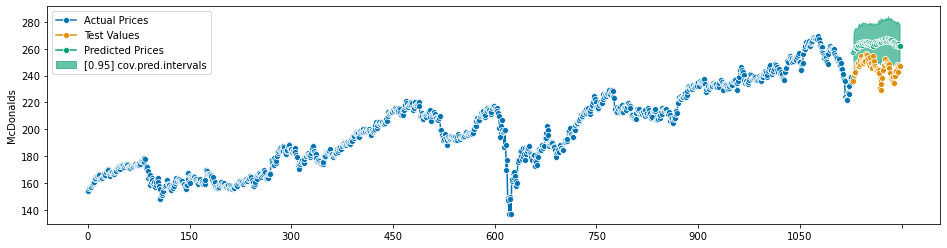

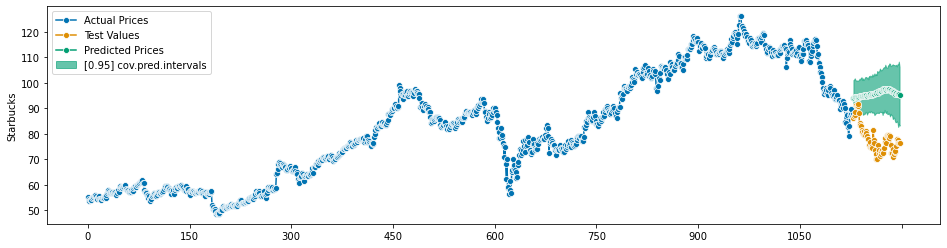

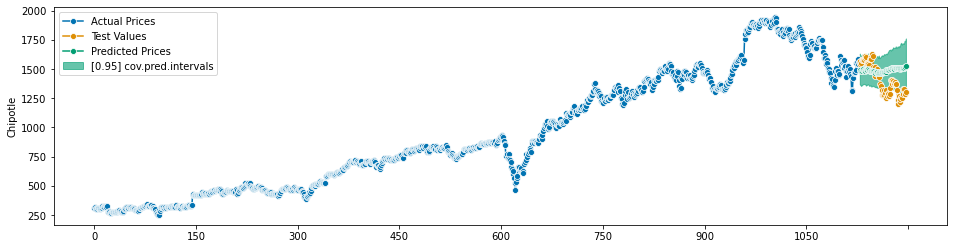

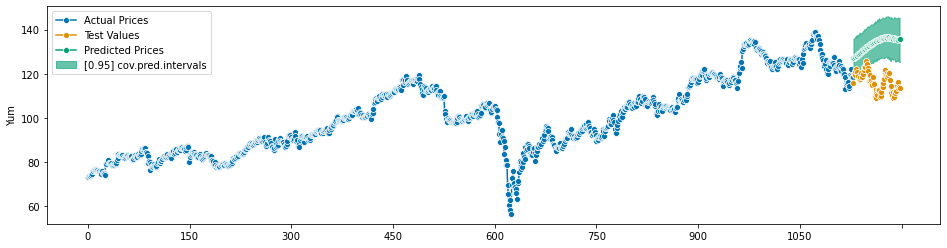

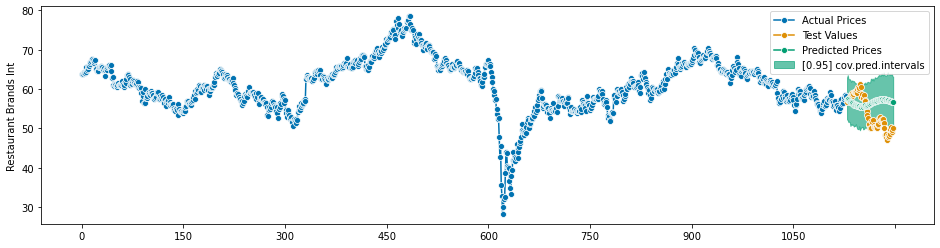

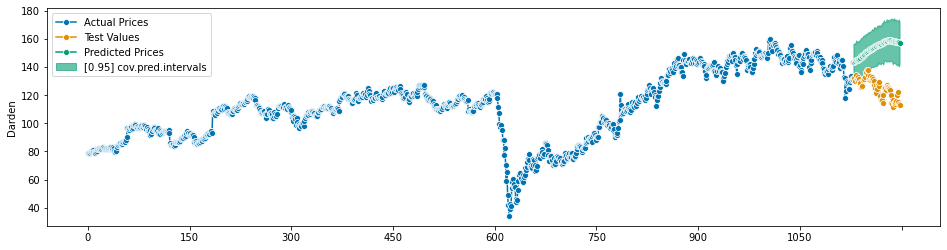

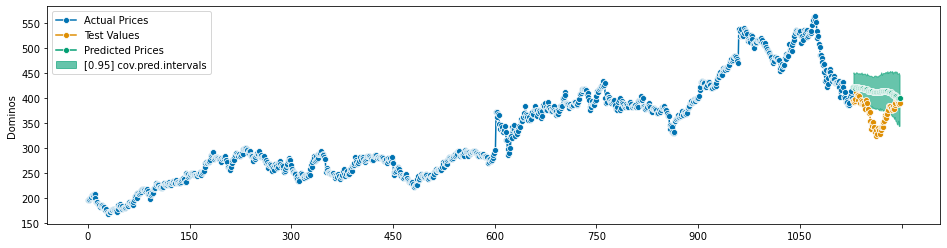

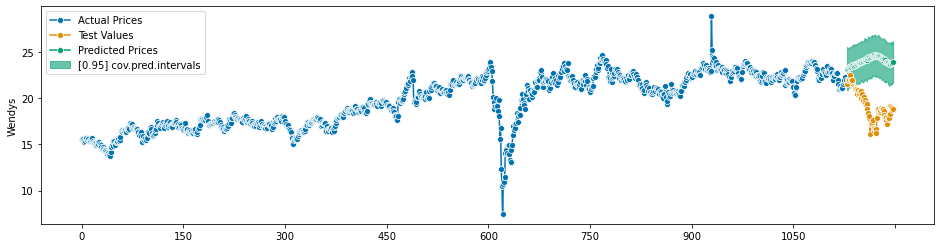

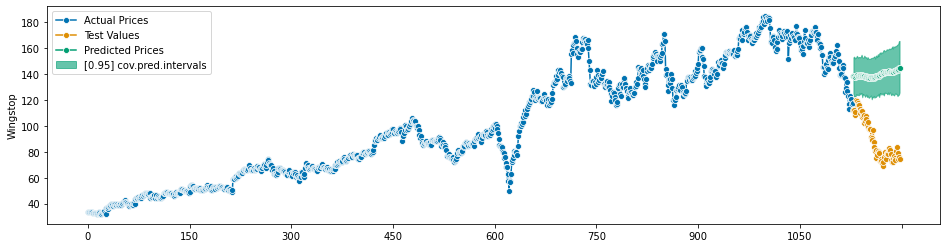

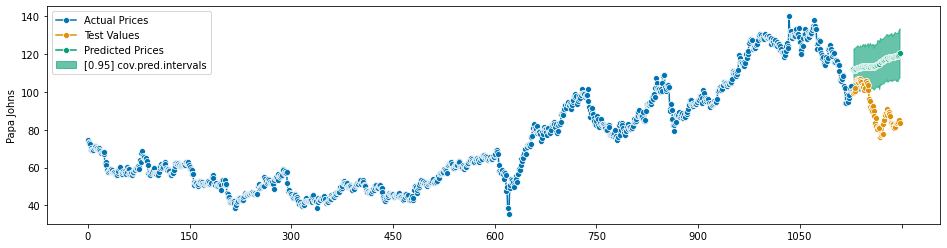

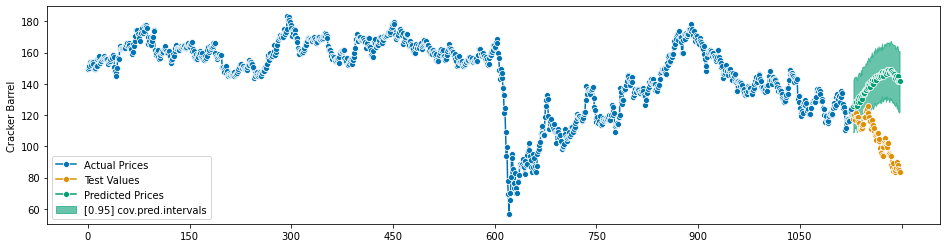

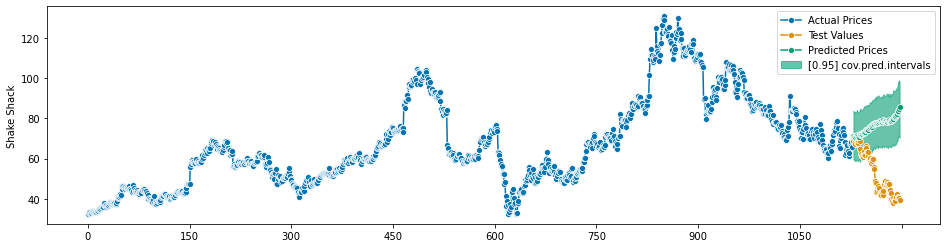

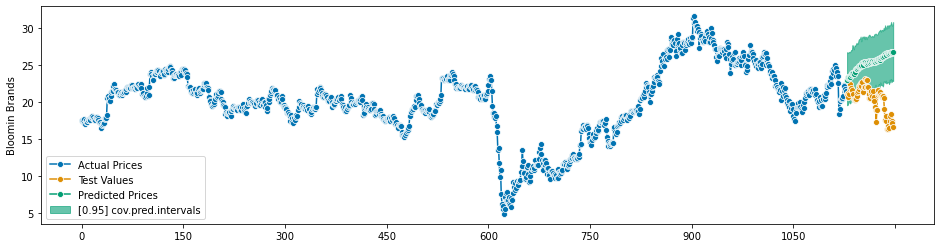

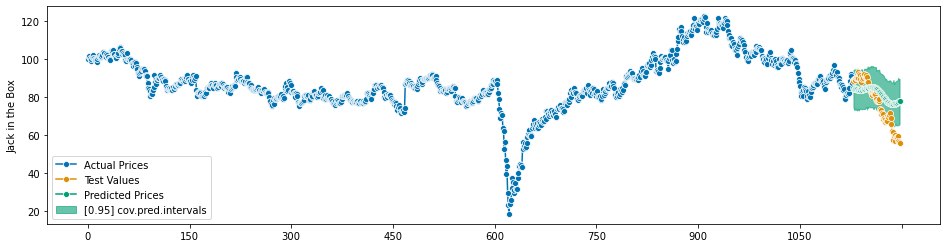

In [46]:
%%time

for x in merged_copy_reset.iloc[:1267, 1:15]:
    prophet(merged_copy_reset.iloc[:1267, 1:15][x])

stop = timeit.default_timer()

In [47]:
prophet_error_dict

{'McDonalds': 7.417765323981176,
 'Starbucks': 23.410977057345043,
 'Chipotle': 9.964098767561582,
 'Yum': 14.749784051995613,
 'Restaurant Brands Int': 9.116141186207523,
 'Darden': 22.84544018420461,
 'Dominos': 11.45956267818712,
 'Wendys': 25.81117959170662,
 'Wingstop': 60.43600823622859,
 'Papa Johns': 27.834162960601965,
 'Cracker Barrel': 35.84510343436148,
 'Shake Shack': 52.601364362965484,
 'Bloomin Brands': 25.277164800499907,
 'Jack in the Box': 12.006046206212414}

In [48]:
#A DataFrame of prophet MAPEs
prophet_errors= sorted(prophet_error_dict.items(), key=itemgetter(0), reverse=False)
pro_stock_diffs_error_per= pd.DataFrame(prophet_errors)
pro_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Prophet Percent Error'}, inplace=True )
pro_stock_diffs_error_per

Stock  Prophet Percent Error
0          Bloomin Brands              25.277165
1                Chipotle               9.964099
2          Cracker Barrel              35.845103
3                  Darden              22.845440
4                 Dominos              11.459563
5         Jack in the Box              12.006046
6               McDonalds               7.417765
7              Papa Johns              27.834163
8   Restaurant Brands Int               9.116141
9             Shake Shack              52.601364
10              Starbucks              23.410977
11                 Wendys              25.811180
12               Wingstop              60.436008
13                    Yum              14.749784

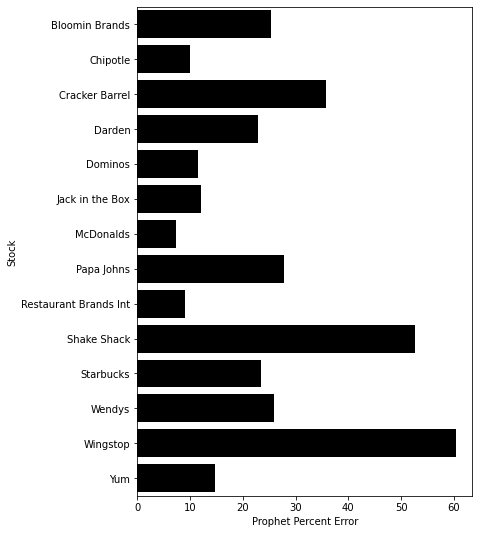

In [49]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Prophet Percent Error',y='Stock', data=pro_stock_diffs_error_per, color="black");

We can see that the MAPEs are too high to be used. Let's try another model:

# LSTM

First, let's incorporate the death predictions into the data:

In [50]:
death_preds = pd. read_excel ("7day_delay_withmy_preds.xlsx")
death_preds.set_index('ds', inplace=True)
death_preds

y
ds                     
2020-01-23     0.000000
2020-01-24     0.000000
2020-01-25     0.000000
2020-01-26     0.000000
2020-01-27     0.000000
...                 ...
2022-12-26  1089.821129
2022-12-27  1494.408305
2022-12-28  1611.934845
2022-12-29  1470.535711
2022-12-30  1587.359891

[1055 rows x 1 columns]

In [51]:
#Merger of death preds and 
merged_preds=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds.index)
merged_preds.fillna(0, inplace=True)
merged_preds.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#merged_copy=merged.copy(deep=True)
merged_preds.set_index('Dates', inplace=True)
merged_preds


McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box       deaths  
Dates                                     
2017-09-27       100.199997     0.000000  
2017-09-28       101.040001     0.000000  
2017-09-29       101.919998     0.000000  
2017-10-02       100.589996     0.000000  
2017-10-03        99.339996     0.000000  
...                     ...          ...  
2022-12-26         0.000000  1089.821129  
2022-12-27         0.000000  1494.408305  
2022-12-28         0.000000  1611.934845  
2022-12-29         0.000000  1470.535711  
2022-12-30         0.000000  1587.359891  

[1335 rows x 15 columns]

Now, I will build and evaluate an LSTM model:

In [52]:
next_

y
ds                   
2022-07-24  13.304135
2022-07-25  17.521415
2022-07-26  25.258662
2022-07-27  26.608269
2022-07-28  22.956481
...               ...
2022-10-05  13.527749
2022-10-06  21.330729
2022-10-07  27.129320
2022-10-10  25.534291
2022-10-11  18.000000

[76 rows x 1 columns]

Now, for the LSTM error calculation, I am going to use the average of 3 results. For example, instead of using the result for 1 LSTM on McDonald's stock, I am using the average of 3 results to determine the reliability of the results. 

In [53]:
death_nums= merged_insample[['deaths']]
stock_error=dict();
mapes=[]
total=[]
loops=3
#This will allow me to do 3 loops. 
for n in range(loops):

    

    for x in merged_copy.iloc[:, :14]:
        #Making a DataFrame that contains only the selected stock and the death numbers
        exogenous_df=death_nums.merge(merged_copy[x], how='left',left_on=death_nums.index, right_on=merged_copy[x].index)
        exogenous_df.set_index('key_0', inplace=True)
        #Creating training set
        training = exogenous_df.iloc[:1129]

        #"next_" would be properly called a validation set
        next_= exogenous_df.iloc[1129:1200]
    
        # Using the create_dataset function to make the DataFrame values into tensors. 
        xtrain, ytrain = create_dataset(training, training.iloc[:,1],2)#Using a lag of 2 to reflect market's responsiveness
        xnext, ynext=create_dataset(next_, next_.iloc[:,1],2)
        model_1 = Sequential()
        model_1.add(LSTM(69,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
        model_1.add(Dense(25))
        model_1.add(Dense(1))
        model_1.compile(loss="mean_squared_error", optimizer="adam")

        model_1.fit(xtrain, ytrain,
                    epochs=10,
                    batch_size=10,
                    verbose=1,
                    shuffle=False
                   )

        ypred = model_1.predict(xnext)
        print(x,'equity mape', (mean_absolute_percentage_error(ypred, next_.iloc[:69,1])))
   
        ypred = asarray(ypred)
        for pred in ypred[:]:
            interval = 1.96 * ypred.std()
            lower, upper = ypred - interval, ypred + interval
        # Remove comments below to see graphs
        #plt.figure(figsize=(12,7))
        #plt.plot(merged_copy.index[1129:1198], ypred, 'r', label="Predictions")
        #plt.plot(merged_copy.index[1129:1198], next_.iloc[:69,1], 'b', label="Actual")
        #plt.fill_between(merged_copy.index[1129:1198], lower[:, 0], upper[:, 0], color="green", alpha=0.5)
        #plt.xlabel("Date")
        #plt.ylabel("Day End Price")
        #plt.legend(['Predictions', 'Actual Prices', 'Confidence Intervals'], loc='upper left')    

        #plt.title(f'{x} Price over Time')
        
        mape_=mean_absolute_percentage_error(ypred, next_.iloc[:69,1])
        stock_error[x]=mape_

        total.append(stock_error[x])
        mapes.append(total)
       



Epoch 1/10
113/113 [==============================] - 4s 6ms/step - loss: 8790.9961
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 8334.7246
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 618.6572
Epoch 4/10
113/113 [==============================] - 1s 7ms/step - loss: 323.1459
Epoch 5/10
113/113 [==============================] - 1s 6ms/step - loss: 442.4497
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 256.3046
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 116.5806
Epoch 8/10
113/113 [==============================] - 1s 6ms/step - loss: 164.4939
Epoch 9/10
113/113 [==============================] - 1s 6ms/step - loss: 289.5539
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
McDonalds equity mape 0.092249178819732
Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 4589.0386
Epoch 2/10
113/113 [==============================] - 1s 5ms/ste

113/113 [==============================] - 1s 5ms/step - loss: 124.9895
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 225.9925
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 388.5576
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 181.0837
Epoch 8/10
113/113 [==============================] - 1s 5ms/step - loss: 118.2607
Epoch 9/10
113/113 [==============================] - 1s 5ms/step - loss: 94.9525
Epoch 10/10
3/3 [==============================] - 1s 5ms/step
Wendys equity mape 1.4079506641632584
Epoch 1/10
113/113 [==============================] - 4s 4ms/step - loss: 8831.6074
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 2910.1501
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 1079.5831
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 1391.3660
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 722

113/113 [==============================] - 1s 8ms/step - loss: 4852.4878
Epoch 3/10
113/113 [==============================] - 1s 7ms/step - loss: 4270.4199
Epoch 4/10
113/113 [==============================] - 1s 6ms/step - loss: 7858.4985
Epoch 5/10
113/113 [==============================] - 1s 7ms/step - loss: 1562.2209
Epoch 6/10
113/113 [==============================] - 1s 7ms/step - loss: 1048.0333
Epoch 7/10
113/113 [==============================] - 1s 11ms/step - loss: 1325.4784
Epoch 8/10
113/113 [==============================] - 1s 10ms/step - loss: 1178.7998
Epoch 9/10
113/113 [==============================] - 1s 9ms/step - loss: 1207.3844
Epoch 10/10
3/3 [==============================] - 1s 6ms/step
Chipotle equity mape 0.08069490789248396
Epoch 1/10
113/113 [==============================] - 4s 7ms/step - loss: 4629.6880
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 914.3155
Epoch 3/10
113/113 [==============================] - 1s 6ms/step 

Cracker Barrel equity mape 0.030404255252706854
Epoch 1/10
113/113 [==============================] - 3s 3ms/step - loss: 918.6816
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 2215.4082
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 228.1975
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 257.0374
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 322.6765
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 327.6654
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 329.4822
Epoch 8/10
113/113 [==============================] - 0s 4ms/step - loss: 595.9274
Epoch 9/10
113/113 [==============================] - 0s 4ms/step - loss: 689.7426
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Shake Shack equity mape 0.24511697353319636
Epoch 1/10
113/113 [==============================] - 3s 5ms/step - loss: 25729.1406
Epoch 2/10
1

113/113 [==============================] - 0s 3ms/step - loss: 178.0089
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Darden equity mape 0.020769233175111586
Epoch 1/10
113/113 [==============================] - 3s 3ms/step - loss: 11333.8057
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 2955.7786
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 7770.3711
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 1776.1560
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 304.9683
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 504.2497
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 515.2267
Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 678.8489
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 233.2139
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Dominos eq

In [54]:
# Putting numbers on each MAPE
dicts = {}
length=14
keys = range(length)
values =[total]

nn=dict(list(enumerate(total)))
nn

{0: 0.092249178819732,
 1: 0.021144968065302545,
 2: 0.012576806066801003,
 3: 0.06990770037625609,
 4: 0.05480376384005048,
 5: 0.05210362646890603,
 6: 0.14440821794223746,
 7: 1.4079506641632584,
 8: 0.10044649267149215,
 9: 0.04294153347066645,
 10: 0.03523541982750805,
 11: 0.1144549526282076,
 12: 2.00931212202101,
 13: 0.06656395335386746,
 14: 0.07998790325651249,
 15: 0.13915741933833012,
 16: 0.08069490789248396,
 17: 0.034409017242578714,
 18: 0.08249408793096726,
 19: 0.05136225441248736,
 20: 0.06514417441398905,
 21: 0.4532289929018358,
 22: 0.08468525823420305,
 23: 0.08623683157951754,
 24: 0.030404255252706854,
 25: 0.24511697353319636,
 26: 1.0177971809847821,
 27: 0.10289166670973288,
 28: 0.0837422792261171,
 29: 0.1420032512784622,
 30: 0.025797860560247764,
 31: 0.13029608359523986,
 32: 0.15190563461363404,
 33: 0.020769233175111586,
 34: 0.08136597230884915,
 35: 1.150209592203236,
 36: 0.027381123406943035,
 37: 0.15538271711705912,
 38: 0.05274344677809027,
 3

In [55]:
merged_copy.iloc[:, :14]

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26         0.000000  
2022-12-27         0.000000  
2022-12-28         0.000000  
2022-12-29         0.000000  
2022-12-30         0.000000  

[1335 rows x 14 columns]

In [56]:
names=[x for x in merged_copy.iloc[:, :14]]
names*3

['McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box',
 'McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box',
 'McDonalds',
 'Starbucks',
 'Chipotle',
 'Yum',
 'Restaurant Brands Int',
 'Darden',
 'Dominos',
 'Wendys',
 'Wingstop',
 'Papa Johns',
 'Cracker Barrel',
 'Shake Shack',
 'Bloomin Brands',
 'Jack in the Box']

In [57]:
#DataFrame OF LSTM MAPEs
lstm_errors= sorted(nn.items(), key=itemgetter(0), reverse=False)
lstm_errors_per= pd.DataFrame(lstm_errors)
lstm_errors_per.rename( columns={0 :'Stock', 1:'LSTM MAPE'}, inplace=True )
lstm_errors_per['Equity']=names*3
lstm_errors_per['LSTM MAPE']=lstm_errors_per['LSTM MAPE']*100
lstm_errors_per


Stock   LSTM MAPE                 Equity
0       0    9.224918              McDonalds
1       1    2.114497              Starbucks
2       2    1.257681               Chipotle
3       3    6.990770                    Yum
4       4    5.480376  Restaurant Brands Int
5       5    5.210363                 Darden
6       6   14.440822                Dominos
7       7  140.795066                 Wendys
8       8   10.044649               Wingstop
9       9    4.294153             Papa Johns
10     10    3.523542         Cracker Barrel
11     11   11.445495            Shake Shack
12     12  200.931212         Bloomin Brands
13     13    6.656395        Jack in the Box
14     14    7.998790              McDonalds
15     15   13.915742              Starbucks
16     16    8.069491               Chipotle
17     17    3.440902                    Yum
18     18    8.249409  Restaurant Brands Int
19     19    5.136225                 Darden
20     20    6.514417                Dominos
21     21   45.322899                 Wendys
22     22    8.468526               Wingstop
23     23    8.623683             Papa Johns
24     24    3.040426         Cracker Barrel
25     25   24.511697            Shake Shack
26     26  101.779718         Bloomin Brands
27     27   10.289167        Jack in the Box
28     28    8.374228              McDonalds
29     29   14.200325              Starbucks
30     30    2.579786               Chipotle
31     31   13.029608                    Yum
32     32   15.190563  Restaurant Brands Int
33     33    2.076923                 Darden
34     34    8.136597                Dominos
35     35  115.020959                 Wendys
36     36    2.738112               Wingstop
37     37   15.538272             Papa Johns
38     38    5.274345         Cracker Barrel
39     39   23.152173            Shake Shack
40     40  166.594164         Bloomin Brands
41     41    9.409816        Jack in the Box

In [58]:
error_means=lstm_errors_per.groupby(['Equity']).mean()
error_means.drop(['Stock'], axis=1, inplace=True)
error_means.reset_index(drop=False, inplace=True)
error_means.rename( columns={'LSTM MAPE' :'Average LSTM MAPE'}, inplace=True )

error_means

Equity  Average LSTM MAPE
0          Bloomin Brands         156.435032
1                Chipotle           3.968986
2          Cracker Barrel           3.946104
3                  Darden           4.141170
4                 Dominos           9.697279
5         Jack in the Box           8.785126
6               McDonalds           8.532645
7              Papa Johns           9.485369
8   Restaurant Brands Int           9.640116
9             Shake Shack          19.703122
10              Starbucks          10.076855
11                 Wendys         100.379642
12               Wingstop           7.083762
13                    Yum           7.820427

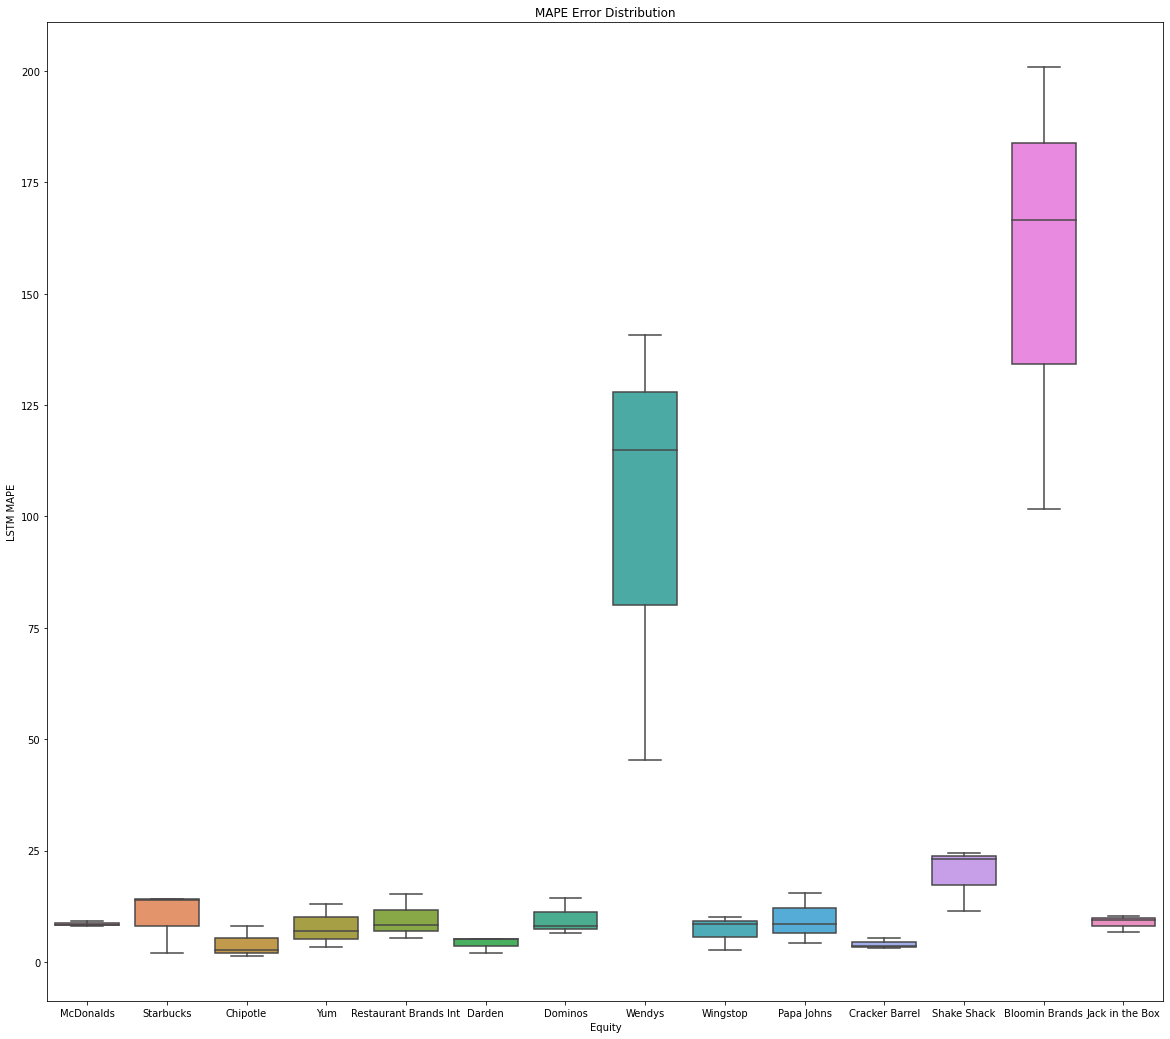

In [59]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.boxplot(data=lstm_errors_per, x='Equity', y='LSTM MAPE')
ax.set_title('MAPE Error Distribution')
plt.show()

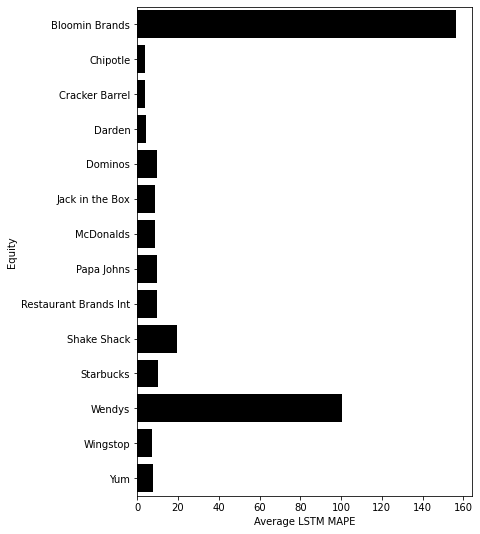

In [60]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Average LSTM MAPE',y='Equity', data=error_means, color="black");

That's not bad but the outliers really harm the model. Also, different iterations of this model will yield different results because LSTMs are stochastic however I did run this many time and the values are similar. 

Let's evaluate model results to see which is the best to use. I would like to use a Group bar chart so we are going to have to combine all of the error values into a DataFrame.

In [61]:
# The names of the new 'model' columns
pm='Auto.arima'
lstm='LSTM'
prop='Prophet'
# Creating the columns
lstm_errors_per = error_means.assign(model=[lstm for x in range(14)])
pm_stock_diffs_error_per=pm_stock_diffs_error_per.assign(model=[pm for x in range(len(pm_stock_diffs_error_per.index))])
pro_stock_diffs_error_per=pro_stock_diffs_error_per.assign(model=[prop for x in range(len(pro_stock_diffs_error_per.index))])
lstm_errors_per

Equity  Average LSTM MAPE model
0          Bloomin Brands         156.435032  LSTM
1                Chipotle           3.968986  LSTM
2          Cracker Barrel           3.946104  LSTM
3                  Darden           4.141170  LSTM
4                 Dominos           9.697279  LSTM
5         Jack in the Box           8.785126  LSTM
6               McDonalds           8.532645  LSTM
7              Papa Johns           9.485369  LSTM
8   Restaurant Brands Int           9.640116  LSTM
9             Shake Shack          19.703122  LSTM
10              Starbucks          10.076855  LSTM
11                 Wendys         100.379642  LSTM
12               Wingstop           7.083762  LSTM
13                    Yum           7.820427  LSTM

In [62]:
#Concatenating columns
errors_combined=pd.concat([lstm_errors_per, pm_stock_diffs_error_per,pro_stock_diffs_error_per])
errors_combined.reset_index(drop=False)
errors_combined

Equity  Average LSTM MAPE       model  \
0          Bloomin Brands         156.435032        LSTM   
1                Chipotle           3.968986        LSTM   
2          Cracker Barrel           3.946104        LSTM   
3                  Darden           4.141170        LSTM   
4                 Dominos           9.697279        LSTM   
5         Jack in the Box           8.785126        LSTM   
6               McDonalds           8.532645        LSTM   
7              Papa Johns           9.485369        LSTM   
8   Restaurant Brands Int           9.640116        LSTM   
9             Shake Shack          19.703122        LSTM   
10              Starbucks          10.076855        LSTM   
11                 Wendys         100.379642        LSTM   
12               Wingstop           7.083762        LSTM   
13                    Yum           7.820427        LSTM   
0                     NaN                NaN  Auto.arima   
1                     NaN                NaN  Auto.arima   
2                     NaN                NaN  Auto.arima   
3                     NaN                NaN  Auto.arima   
4                     NaN                NaN  Auto.arima   
5                     NaN                NaN  Auto.arima   
6                     NaN                NaN  Auto.arima   
7                     NaN                NaN  Auto.arima   
8                     NaN                NaN  Auto.arima   
9                     NaN                NaN  Auto.arima   
10                    NaN                NaN  Auto.arima   
11                    NaN                NaN  Auto.arima   
12                    NaN                NaN  Auto.arima   
13                    NaN                NaN  Auto.arima   
0                     NaN                NaN     Prophet   
1                     NaN                NaN     Prophet   
2                     NaN                NaN     Prophet   
3                     NaN                NaN     Prophet   
4                     NaN                NaN     Prophet   
5                     NaN                NaN     Prophet   
6                     NaN                NaN     Prophet   
7                     NaN                NaN     Prophet   
8                     NaN                NaN     Prophet   
9                     NaN                NaN     Prophet   
10                    NaN                NaN     Prophet   
11                    NaN                NaN     Prophet   
12                    NaN                NaN     Prophet   
13                    NaN                NaN     Prophet   

                    Stock  Auto Arima Percent Error  Prophet Percent Error  
0                     NaN                       NaN                    NaN  
1                     NaN                       NaN                    NaN  
2                     NaN                       NaN                    NaN  
3                     NaN                       NaN                    NaN  
4                     NaN                       NaN                    NaN  
5                     NaN                       NaN                    NaN  
6                     NaN                       NaN                    NaN  
7                     NaN                       NaN                    NaN  
8                     NaN                       NaN                    NaN  
9                     NaN                       NaN                    NaN  
10                    NaN                       NaN                    NaN  
11                    NaN                       NaN                    NaN  
12                    NaN                       NaN                    NaN  
13                    NaN                       NaN                    NaN  
0                     Yum                  3.369135                    NaN  
1                Wingstop                 35.081751                    NaN  
2                  Wendys                 14.873851                    NaN  
3               Starbucks                 13.491130 

In [63]:
# Filling the NaNs and adding the error columns together.
errors_combined.fillna(0, inplace=True)
errors_combined['errors']=errors_combined['Average LSTM MAPE']+ errors_combined['Auto Arima Percent Error']+errors_combined['Prophet Percent Error']
errors_combined

Equity  Average LSTM MAPE       model  \
0          Bloomin Brands         156.435032        LSTM   
1                Chipotle           3.968986        LSTM   
2          Cracker Barrel           3.946104        LSTM   
3                  Darden           4.141170        LSTM   
4                 Dominos           9.697279        LSTM   
5         Jack in the Box           8.785126        LSTM   
6               McDonalds           8.532645        LSTM   
7              Papa Johns           9.485369        LSTM   
8   Restaurant Brands Int           9.640116        LSTM   
9             Shake Shack          19.703122        LSTM   
10              Starbucks          10.076855        LSTM   
11                 Wendys         100.379642        LSTM   
12               Wingstop           7.083762        LSTM   
13                    Yum           7.820427        LSTM   
0                       0           0.000000  Auto.arima   
1                       0           0.000000  Auto.arima   
2                       0           0.000000  Auto.arima   
3                       0           0.000000  Auto.arima   
4                       0           0.000000  Auto.arima   
5                       0           0.000000  Auto.arima   
6                       0           0.000000  Auto.arima   
7                       0           0.000000  Auto.arima   
8                       0           0.000000  Auto.arima   
9                       0           0.000000  Auto.arima   
10                      0           0.000000  Auto.arima   
11                      0           0.000000  Auto.arima   
12                      0           0.000000  Auto.arima   
13                      0           0.000000  Auto.arima   
0                       0           0.000000     Prophet   
1                       0           0.000000     Prophet   
2                       0           0.000000     Prophet   
3                       0           0.000000     Prophet   
4                       0           0.000000     Prophet   
5                       0           0.000000     Prophet   
6                       0           0.000000     Prophet   
7                       0           0.000000     Prophet   
8                       0           0.000000     Prophet   
9                       0           0.000000     Prophet   
10                      0           0.000000     Prophet   
11                      0           0.000000     Prophet   
12                      0           0.000000     Prophet   
13                      0           0.000000     Prophet   

                    Stock  Auto Arima Percent Error  Prophet Percent Error  \
0                       0                  0.000000               0.000000   
1                       0                  0.000000               0.000000   
2                       0                  0.000000               0.000000   
3                       0                  0.000000               0.000000   
4                       0                  0.000000               0.000000   
5                       0                  0.000000               0.000000   
6                       0                  0.000000               0.000000   
7                       0                  0.000000               0.000000   
8                       0                  0.000000               0.000000   
9                       0                  0.000000               0.000000   
10                      0                  0.000000               0.000000   
11                      0                  0.000000               0.000000   
12                      0                  0.000000               0.000000   
13                      0                  0.000000               0.000000   
0                     Yum                  3.369135               0.000000   
1                Wingstop                 35.081751               0.000000   
2                  Wendys                 14.873851               0.000000   
3               Starbucks         

The Auto.Arima model was surprisingly good. However, I will still go with the LSTM model because its performance was better but was harmed by a few serious outliers. I will have to either disregard predictions on those equities or be very cautious when drawing conclusions from them.

Ok, Now, I will make out of sample predictions on the LSTM since it performed the best except for a few outliers.

In [64]:
#Opening the death predictions
death_preds = pd.read_excel ("7day_delay_withmy_preds.xlsx")
#Merging with restaurants
full_dataset=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds['ds'])
#Renaming columns
full_dataset.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#Creating a copy before I set index
full_dataset_copy=full_dataset.copy(deep=True)
#Dropping columns
full_dataset.drop('ds', axis=1, inplace=True)
full_dataset.drop('deaths', axis=1, inplace=True)

full_dataset.set_index('Dates', inplace=True)
full_dataset

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26              NaN  
2022-12-27              NaN  
2022-12-28              NaN  
2022-12-29              NaN  
2022-12-30              NaN  

[1335 rows x 14 columns]

I need to immediately eliminate any null from the 'deaths' column:

In [65]:
full_dataset_copy.iloc[1267:]

Dates  McDonalds  Starbucks  Chipotle  Yum  Restaurant Brands Int  \
1267 2022-10-10        NaN        NaN       NaN  NaN                    NaN   
1268 2022-10-11        NaN        NaN       NaN  NaN                    NaN   
1269 2022-10-12        NaN        NaN       NaN  NaN                    NaN   
1270 2022-10-13        NaN        NaN       NaN  NaN                    NaN   
1271 2022-10-14        NaN        NaN       NaN  NaN                    NaN   
...         ...        ...        ...       ...  ...                    ...   
1330 2022-12-26        NaN        NaN       NaN  NaN                    NaN   
1331 2022-12-27        NaN        NaN       NaN  NaN                    NaN   
1332 2022-12-28        NaN        NaN       NaN  NaN                    NaN   
1333 2022-12-29        NaN        NaN       NaN  NaN                    NaN   
1334 2022-12-30        NaN        NaN       NaN  NaN                    NaN   

      Darden  Dominos  Wendys  Wingstop  Papa Johns  Cracker Barrel  \
1267     NaN      NaN     NaN       NaN         NaN             NaN   
1268     NaN      NaN     NaN       NaN         NaN             NaN   
1269     NaN      NaN     NaN       NaN         NaN             NaN   
1270     NaN      NaN     NaN       NaN         NaN             NaN   
1271     NaN      NaN     NaN       NaN         NaN             NaN   
...      ...      ...     ...       ...         ...             ...   
1330     NaN      NaN     NaN       NaN         NaN             NaN   
1331     NaN      NaN     NaN       NaN         NaN             NaN   
1332     NaN      NaN     NaN       NaN         NaN             NaN   
1333     NaN      NaN     NaN       NaN         NaN             NaN   
1334     NaN      NaN     NaN       NaN         NaN             NaN   

      Shake Shack  Bloomin Brands  Jack in the Box         ds       deaths  
1267          NaN             NaN              NaN 2022-10-10   652.000000  
1268          NaN             NaN              NaN 2022-10-11   324.000000  
1269          NaN             NaN              NaN 2022-10-12   841.021577  
1270          NaN             NaN              NaN 2022-10-13   720.838329  
1271          NaN             NaN              NaN 2022-10-14   782.069467  
...           ...             ...              ...        ...          ...  
1330          NaN             NaN              NaN 2022-12-26  1089.821129  
1331          NaN             NaN              NaN 2022-12-27  1494.408305  
1332          NaN             NaN              NaN 2022-12-28  1611.934845  
1333          NaN             NaN              NaN 2022-12-29  1470.535711  
1334          NaN             NaN              NaN 2022-12-30  1587.359891  

[68 rows x 17 columns]

In [66]:
#Eliminating nulls
full_dataset_copy['deaths'].fillna(0, axis=0, inplace=True)

In [67]:
#Setting index
full_dataset_copy.set_index('Dates', inplace=True)


In [68]:
full_dataset

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26              NaN  
2022-12-27              NaN  
2022-12-28              NaN  
2022-12-29              NaN  
2022-12-30              NaN  

[1335 rows x 14 columns]

I am going to make out of sample predictions using the same strategy that I used to make in sample predictions. However, this time I will swap the NaNs and 0s in the price column for the previous mean.

Now, I will predict the future ROI% for each stock. Once again, I will use the average of 3 iterations to calculate the ROI%.

In [69]:
roi=dict();
profit=[]
profs=[]
death_future= full_dataset_copy[['deaths']]
# To execute a 3 for loops
for n in range(loops):

    for x in full_dataset.iloc[:,:]:
        #Merging the death numbers and price numbers
        exogenous_df_preds=death_future.merge(full_dataset[x], how='left',left_on=death_future.index, right_on=full_dataset[x].index)
        #Setting index
        exogenous_df_preds.set_index('key_0', inplace=True)
        #Filling  the empty price dates with the mean of previous values
        exogenous_df_preds.fillna(full_dataset[x].mean(), axis=1, inplace=True)



        training_1 = exogenous_df_preds.iloc[:1127]
        # future_values will be the name of the future data that is disguised as actual data
        future_values= exogenous_df_preds.iloc[1265:]

        xtrain, ytrain = create_dataset(training_1, training_1.iloc[:,1],2)
        xfuture, yfuture=create_dataset(future_values, future_values.iloc[:,1],2)
        model_1 = Sequential()
        model_1.add(LSTM(70,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
        model_1.add(Dense(25))
        model_1.add(Dense(1))
        model_1.compile(loss="mean_squared_error", optimizer="adam")

        model_1.fit(xtrain, ytrain,epochs=10,batch_size=10,verbose=1,shuffle=False)

        ypred_1 = model_1.predict(xfuture)
        ypred_1_array = asarray(ypred_1)
    
        for preds in ypred_1_array[:]:
            interval = 1.96 * ypred_1_array.std()
            lower, upper = ypred_1_array - interval, ypred_1_array + interval

        # Remove comments below to graph each result
        #plt.figure(figsize=(12,7))
        #plt.plot(merged_copy.index[:1267], full_dataset[x][:1267], 'green', label='Actual Prices')
        #plt.plot(merged_copy.index[1267:], ypred_1_array, 'r', label="Predictions")
    
        #plt.fill_between(merged_copy.index[1267:], lower[:, 0], upper[:, 0], color="purple", alpha=0.5)
        #plt.xlabel("Date")
        #plt.ylabel("Day End Price")
        #plt.legend([ 'Actual Prices', ' Predictions'], loc='upper left')    

        #plt.title(f'{x} Price over Time')
        final_observed=full_dataset[x][1266]
    
        diff=ypred_1[65,0]-full_dataset[x][1266]
        rois=diff/final_observed
        
        roi[x]=rois*100
        profit.append(roi[x])
        profs.append(profit)

Epoch 1/10
113/113 [==============================] - 3s 3ms/step - loss: 11968.0361
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 806.6226
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 324.8391
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 664.9867
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 402.5525
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 969.0482
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 1129.8521
Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 1426.9684
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 1564.7401
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
113/113 [==============================] - 3s 3ms/step - loss: 45260.3633
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 4386.7656
Epoch 3/10
113/1

113/113 [==============================] - 0s 3ms/step - loss: 890.3469
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 968.7039
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 2176.4873
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 2797.5928
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 411.0079
Epoch 8/10
113/113 [==============================] - 0s 4ms/step - loss: 433.9124
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 547.0046
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 9466.0928
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 1318.7648
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 2236.6399
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 987.1658
Epoch 5/10
113/113 [==========

113/113 [==============================] - 0s 3ms/step - loss: 314.6784
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 161.9355
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 445.2409
Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 548.5591
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 380.0304
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
113/113 [==============================] - 4s 5ms/step - loss: 2587.6318
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 402.9172
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 264.5010
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 300.9916
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 230.6903
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 164.4161
Epoch 7/10
113/113 [==============

Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 629.3522
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 155.8024
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 10250.0000
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 589.5112
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 504.2942
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 620.2355
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 948.6390
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 706.7743
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 965.1120
Epoch 8/10
113/113 [==============================] - 0s 3ms/step - loss: 684.5552
Epoch 9/10
113/113 [==============================] - 0s 3ms/step - loss: 432.7188
Epoch 10/10
3/3 [=====

3/3 [==============================] - 0s 5ms/step
Epoch 1/10
113/113 [==============================] - 3s 5ms/step - loss: 2144.2158
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 765.8135
Epoch 3/10
113/113 [==============================] - 1s 6ms/step - loss: 534.5197
Epoch 4/10
113/113 [==============================] - 1s 6ms/step - loss: 163.8388
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 146.9756
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 101.0864
Epoch 7/10
113/113 [==============================] - 1s 7ms/step - loss: 63.9272
Epoch 8/10
113/113 [==============================] - 1s 5ms/step - loss: 40.9364
Epoch 9/10
113/113 [==============================] - 0s 4ms/step - loss: 90.1060
Epoch 10/10
3/3 [==============================] - 0s 5ms/step
Epoch 1/10
113/113 [==============================] - 3s 5ms/step - loss: 11003.3506
Epoch 2/10
113/113 [==============================] - 1s

# Results

In [70]:
# Putting numbers on each ROI
dicts = {}
length=14
keys = range(length)
values =[profit]

profits=dict(list(enumerate(profit)))
profits

{0: -20.176241807746635,
 1: -7.702761902886398,
 2: -32.33600783094746,
 3: -7.800402510410217,
 4: -32.52147659246335,
 5: -51.28798820549628,
 6: 10.573155513386476,
 7: -68.82102626780565,
 8: -33.617703635199106,
 9: -10.422998871578343,
 10: 59.96131458981171,
 11: 12.294115175601378,
 12: -61.347949406332226,
 13: -37.605203992148304,
 14: -9.634937158942277,
 15: -11.275971254973143,
 16: -30.212467073147064,
 17: -2.7938093351593403,
 18: -8.323825784405022,
 19: -30.266277802778664,
 20: 10.568517524596018,
 21: -65.20158258408152,
 22: -13.540825879484633,
 23: 13.805260988745346,
 24: 32.827375025094824,
 25: 1.3117006080874234,
 26: -36.45458182027517,
 27: 23.35400023189277,
 28: -12.854332913460457,
 29: -18.82214638798672,
 30: -32.18304401830927,
 31: -3.6817341416398497,
 32: 14.002625223464976,
 33: -18.45728133437798,
 34: -0.2729753312090588,
 35: -21.818853048753994,
 36: -23.58903932452499,
 37: 25.224747210654247,
 38: 55.28293148685244,
 39: 14.904090356816575,

In [71]:
equity_rois= sorted(profits.items(), key=itemgetter(0), reverse=False)
equity_rois_per= pd.DataFrame(equity_rois)
equity_rois_per.rename( columns={0 :'Stock', 1:'ROI'}, inplace=True )
equity_rois_per['Equity']=names*3
equity_rois_per

Stock        ROI                 Equity
0       0 -20.176242              McDonalds
1       1  -7.702762              Starbucks
2       2 -32.336008               Chipotle
3       3  -7.800403                    Yum
4       4 -32.521477  Restaurant Brands Int
5       5 -51.287988                 Darden
6       6  10.573156                Dominos
7       7 -68.821026                 Wendys
8       8 -33.617704               Wingstop
9       9 -10.422999             Papa Johns
10     10  59.961315         Cracker Barrel
11     11  12.294115            Shake Shack
12     12 -61.347949         Bloomin Brands
13     13 -37.605204        Jack in the Box
14     14  -9.634937              McDonalds
15     15 -11.275971              Starbucks
16     16 -30.212467               Chipotle
17     17  -2.793809                    Yum
18     18  -8.323826  Restaurant Brands Int
19     19 -30.266278                 Darden
20     20  10.568518                Dominos
21     21 -65.201583                 Wendys
22     22 -13.540826               Wingstop
23     23  13.805261             Papa Johns
24     24  32.827375         Cracker Barrel
25     25   1.311701            Shake Shack
26     26 -36.454582         Bloomin Brands
27     27  23.354000        Jack in the Box
28     28 -12.854333              McDonalds
29     29 -18.822146              Starbucks
30     30 -32.183044               Chipotle
31     31  -3.681734                    Yum
32     32  14.002625  Restaurant Brands Int
33     33 -18.457281                 Darden
34     34  -0.272975                Dominos
35     35 -21.818853                 Wendys
36     36 -23.589039               Wingstop
37     37  25.224747             Papa Johns
38     38  55.282931         Cracker Barrel
39     39  14.904090            Shake Shack
40     40 -59.355184         Bloomin Brands
41     41  33.361592        Jack in the Box

In [72]:
roi_means=equity_rois_per.groupby(['Equity']).mean()
roi_means.drop(['Stock'], axis=1, inplace=True)
roi_means.reset_index(drop=False, inplace=True)
roi_means.rename( columns={'ROI':'Average ROI'}, inplace=True )

roi_means

Equity  Average ROI
0          Bloomin Brands   -52.385905
1                Chipotle   -31.577173
2          Cracker Barrel    49.357207
3                  Darden   -33.337182
4                 Dominos     6.956233
5         Jack in the Box     6.370129
6               McDonalds   -14.221837
7              Papa Johns     9.535670
8   Restaurant Brands Int    -8.947559
9             Shake Shack     9.503302
10              Starbucks   -12.600293
11                 Wendys   -51.947154
12               Wingstop   -23.582523
13                    Yum    -4.758649

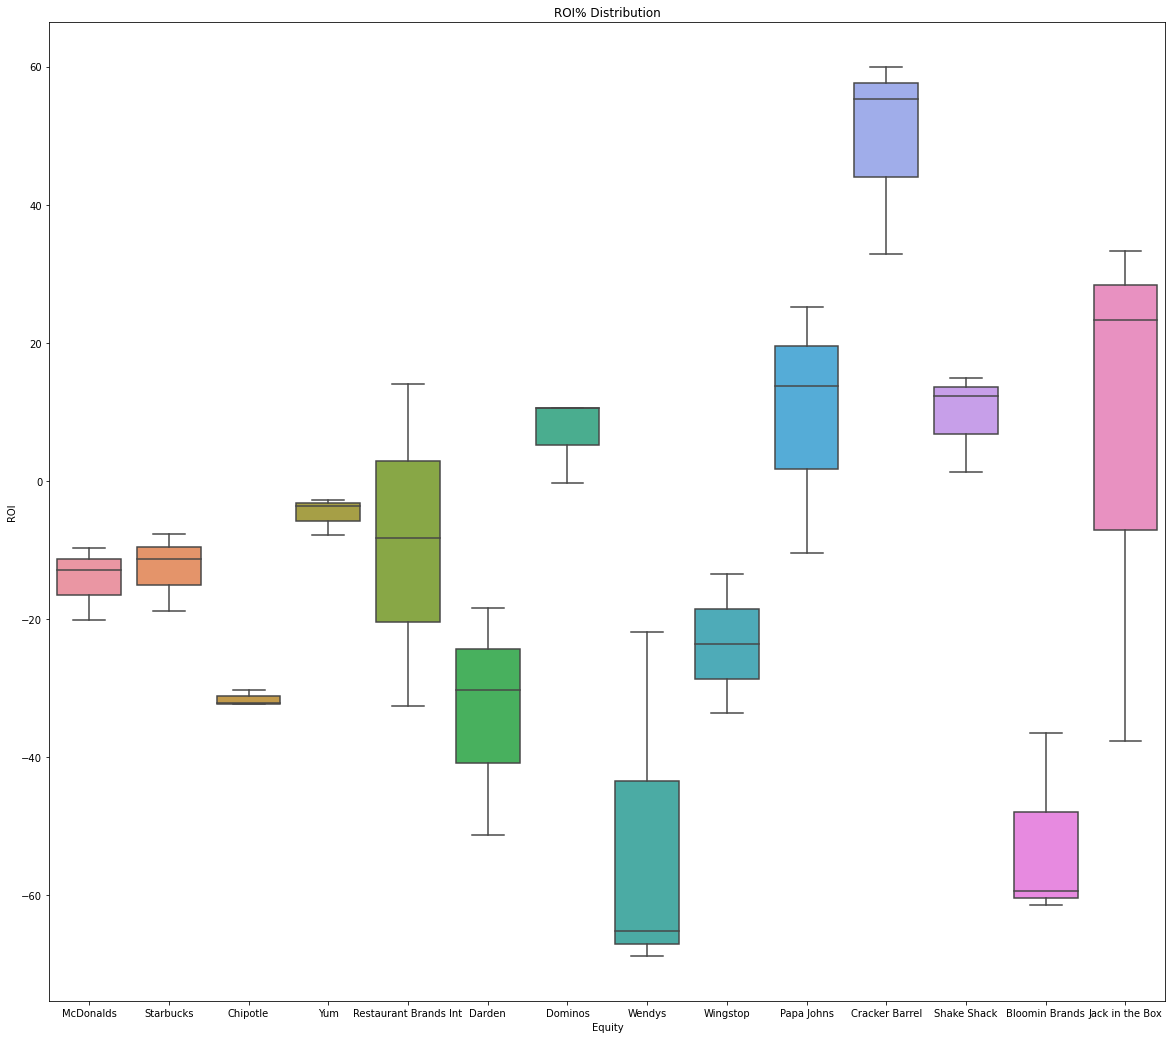

In [73]:
fig, ax = plt.subplots(figsize=(20, 18))
sns.boxplot(data=equity_rois_per, x='Equity', y='ROI')
ax.set_title('ROI% Distribution')
plt.show()

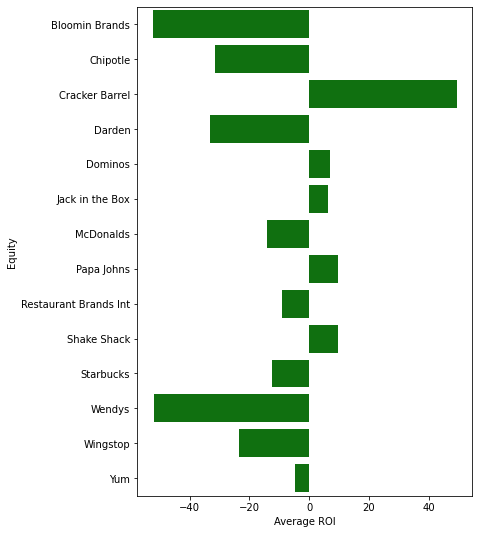

In [74]:
f, ax = plt.subplots(figsize=(6, 9))
sns.barplot(x='Average ROI',y='Equity', data=roi_means, color="green");

**Here are the results:**

The results look good but there are a few caveats namely that the training errors for some of the equities were so high that they cannot be relied upon. Therefore, let's eliminate the stocks with high MAPEs: Wendys, Bloomin Brands, and Shake Shack because their MAPE is over 10%. 

### TOP 3 PERFORMERS

The top 3 performers were Cracker Barrel, Papa Johns, and Dominos. 

![image](https://user-images.githubusercontent.com/101752113/197632503-a8760f24-c62a-4eea-bfb2-ea9770857f06.png)

Here are the bottom 3 performers: Darden, Chipotle, and Wingstop.

### BOTTOM 3 PERFORMERS


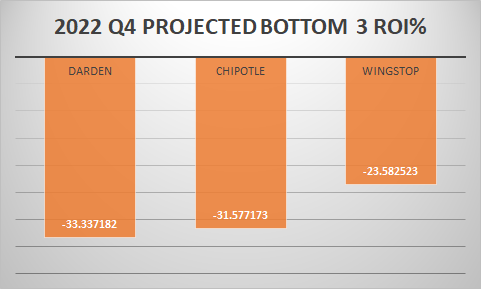

# CONCLUSION

**The top performers were Cracker Barrel, Papa Johns, and Dominos while the poorest performers were Darden, Chipotle, and Wingstop**. The model’s results will help investors hoping for insight into the restaurant industry’s Q4 performance. Especially important in this model is its incorporation of COVID-19 death numbers. Thankfully, my prediction for COVID deaths are probably too high but there are no available datasets available that make better predictions at the same 2.5 month interval. In fact, most predictions only predict for 4 weeks and not on individual days. 


This notebook is a very fruitful start for modeling stock prices. However, some of its assumption could justifiably be questioned. The temporal link between COVID deaths and stock prices is real but the exact amount of time is not entirely clear. In fact, there is good evidence that it is actually much longer than I assume here. Moreover, there is good evidence that in-person dining actually effects COVID rates so these 2 variables could very well be in a feedback loop:

https://journals.lww.com/epidem/fulltext/2022/03000/the_impact_of_keeping_indoor_dining_closed_on.7.aspx

More exogenous variables like real estate prices, volume, commodities prices, inflation rate and interest rates would certainly enhance this dataset and its analysis.

Overall, the model provides a great beginning for modeling stock prices.
